## Final Project Submission

Please fill out:
* Student name: Chris Grannan
* Student pace: self paced
* Scheduled project review date/time: TBA
* Instructor name:  Eli Thomas
* Blog post URL: https://cgrannan.github.io/which_features_should_i_use


## Introduction

For this project we are going to create a multivariate linear model to predict prices of houses.  To create this model we will use a dataset of house sales from King County, Washington from 2014/2015.  We will follow the OSEMN process to prepare our model.

## OSEMN

Here we will detail the OSEMN process.

#### O - Obtain:
    This step involves importing data and all relevant libraries.
#### S - Scrub:
    During this step we will identify and fill null values and clean our data.
#### E - Explore:
    This step can be mixed with scrubbing.  Here we will investigate our data and look for patterns.
#### M - Model:
    Here we will use our data to build a model to predict our target variable.
#### N - iNterpret:
    Finally we will interpret the results of our model and communicate our findings to stakeholders.

## Loading in Data

First we're going to import relevant libraries and load the data into the notebook.

In [1]:
#Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('seaborn')
import statsmodels.api as sm
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

#Load and inspect data
df = pd.read_csv('kc_house_data.csv')
df.head(), df.tail()

(           id        date     price  bedrooms  bathrooms  sqft_living  \
 0  7129300520  10/13/2014  221900.0         3       1.00         1180   
 1  6414100192   12/9/2014  538000.0         3       2.25         2570   
 2  5631500400   2/25/2015  180000.0         2       1.00          770   
 3  2487200875   12/9/2014  604000.0         4       3.00         1960   
 4  1954400510   2/18/2015  510000.0         3       2.00         1680   
 
    sqft_lot  floors  waterfront  view     ...      grade  sqft_above  \
 0      5650     1.0         NaN   0.0     ...          7        1180   
 1      7242     2.0         0.0   0.0     ...          7        2170   
 2     10000     1.0         0.0   0.0     ...          6         770   
 3      5000     1.0         0.0   0.0     ...          7        1050   
 4      8080     1.0         0.0   0.0     ...          8        1680   
 
    sqft_basement yr_built  yr_renovated  zipcode      lat     long  \
 0            0.0     1955           0.0   

## Scrubbing the Data

In this section we are going to resolve missing data and prepare data for modeling.  We will start by looking at some descriptive features of the data.

In [2]:
len(df)

21597

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.5+ MB


Let's unpack some of this information.  First, the id and date columns are not going to hold information that is relevant to our investigation.  We will drop them from the dataframe.  The lattitutde, longitude, and zip code columns are going to be tricky to work with.  I don't want to drop all of this information as location is important in real estate pricing.  Latitude and longitude are not going to be workable in our linear model, so we will drop them, but let's come back to zip code to see if we can work with it.  We also need to investigate sqft_basement data because that should be a numerical datatype, not an object.

In [4]:
df.drop(['id', 'date', 'lat', 'long'], axis=1, inplace=True)

In [5]:
df.sqft_basement.value_counts()

0.0       12826
?           454
600.0       217
500.0       209
700.0       208
800.0       201
400.0       184
1000.0      148
300.0       142
900.0       142
200.0       105
750.0       104
450.0       103
530.0       103
480.0       103
720.0        98
620.0        90
580.0        84
840.0        83
420.0        81
860.0        79
1100.0       78
670.0        78
780.0        76
550.0        76
650.0        75
240.0        74
380.0        73
680.0        73
360.0        72
          ...  
1525.0        1
207.0         1
666.0         1
2600.0        1
1284.0        1
3260.0        1
1248.0        1
2120.0        1
1920.0        1
417.0         1
2580.0        1
475.0         1
4130.0        1
143.0         1
935.0         1
1548.0        1
2180.0        1
506.0         1
225.0         1
1960.0        1
3500.0        1
176.0         1
2300.0        1
415.0         1
2390.0        1
652.0         1
784.0         1
20.0          1
1770.0        1
2490.0        1
Name: sqft_basement, Len

There are some "?" values in there.  Let's change those to 0, and assume that there is no basement in these houses.  There are only 454 of these values, so it shouldn't mess with our data much.  We will also change the type of the category to float to make sure there aren't any strings hidden inside this column.

In [6]:
basement_float = df.sqft_basement[df.sqft_basement != '?']
basement_float = basement_float.astype('float')
basement_mean = round(np.mean(basement_float), 2)
df.sqft_basement= df.sqft_basement.map(lambda x: basement_mean if x == '?' else x)
df.sqft_basement = df.sqft_basement.astype('float')

Now that this is resolved, lets look for missing values.

In [7]:
# See how many null values by column
df.isna().sum()

price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
sqft_living15       0
sqft_lot15          0
dtype: int64

In [8]:
df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,sqft_living15,sqft_lot15
count,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,19221.000000,21534.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,17755.000000,21597.000000,21597.000000,21597.000000
mean,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,0.007596,0.233863,3.409825,7.657915,1788.596842,291.851688,1970.999676,83.636778,98077.951845,1986.620318,12758.283512
std,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,0.086825,0.765686,0.650546,1.173200,827.759761,437.822440,29.375234,399.946414,53.513072,685.230472,27274.441950
min,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,3.000000,370.000000,0.000000,1900.000000,0.000000,98001.000000,399.000000,651.000000
25%,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,1490.000000,5100.000000
50%,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,1840.000000,7620.000000
75%,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,550.000000,1997.000000,0.000000,98118.000000,2360.000000,10083.000000
max,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,6210.000000,871200.000000


We have some missing values in the waterfront, view and yr_renovated columns.  We are going to replace those values with zeros because in all three columns, 0 is the median value.  None of these columns have significant amounts of missing data, so changing these values shouldn't affect our results much.

In [9]:
df = df.fillna(0)
df.isna().sum()

price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
sqft_living15    0
sqft_lot15       0
dtype: int64

## Exploring the Data

Now let's look at the distributions of our data. We will pull up a histogram of every column to show the shape of the distribution.  We will also look for anomolies, or how we might be able to improve a column through restructuring or transforming the data.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c16f50b38>,
      dtype=object)

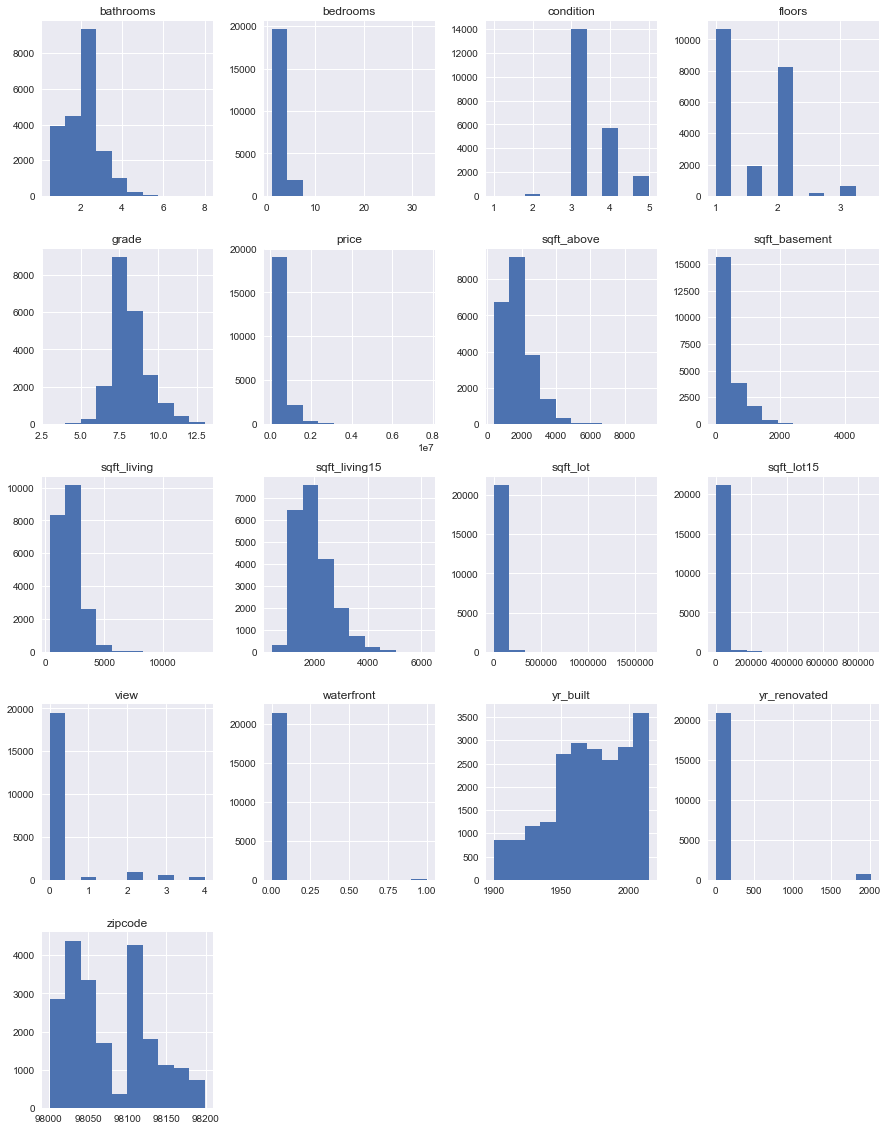

In [10]:
df.hist(figsize=(15,20))

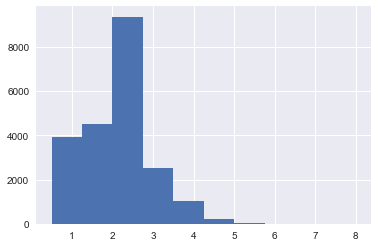

In [11]:
df.bathrooms.hist()

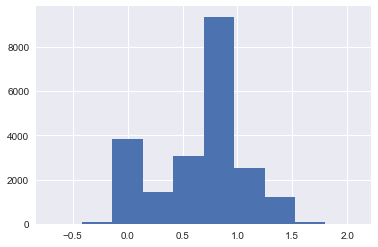

In [12]:
df.bathrooms = np.log(df.bathrooms)
df.bathrooms.hist()

The bathroom data looks workable.  We log-transformed the data to make it more normally distributed.

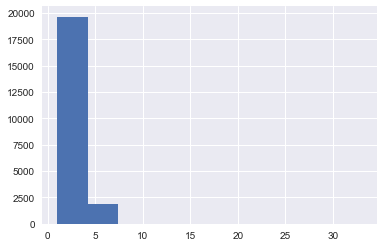

In [13]:
df.bedrooms.hist()

3     9824
4     6882
2     2760
5     1601
6      272
1      196
7       38
8       13
9        6
10       3
11       1
33       1
Name: bedrooms, dtype: int64


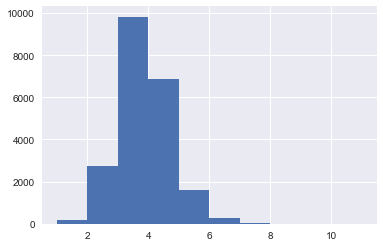

In [14]:
print(df.bedrooms.value_counts())
df.drop(df.index[df.bedrooms > 11], inplace=True)
df.bedrooms.hist()

The bedrooms column had a weird outlier with 33 bedrooms.  If this datapoint is accurate, then I expect it to be an outlier in several categories.  If it is inaccurate, then it should be removed from our data.  Either way it should be removed from our dataset.  After removing the outlier, our data is fairly normal in distribution.

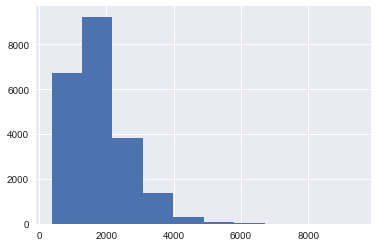

In [15]:
df.sqft_above.hist()

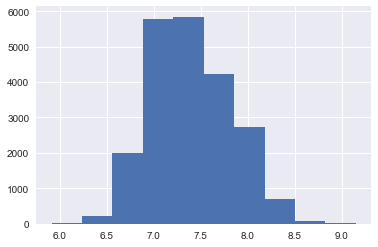

In [16]:
df.sqft_above = np.log(df.sqft_above)
df.sqft_above.hist()

We logtransformed the sqft_above column to give a nice normal distribution.

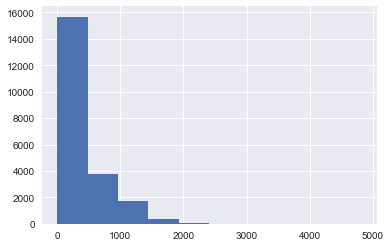

In [17]:
df.sqft_basement.hist()

In [18]:
df['basement'] = df.sqft_basement.map(lambda x: 0 if x == 0 else 1)
df.drop(['sqft_basement'], axis=1, inplace=True)
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,sqft_living15,sqft_lot15,basement
0,221900.0,3,0.000000,1180,5650,1.0,0.0,0.0,3,7,7.073270,1955,0.0,98178,1340,5650,0
1,538000.0,3,0.810930,2570,7242,2.0,0.0,0.0,3,7,7.682482,1951,1991.0,98125,1690,7639,1
2,180000.0,2,0.000000,770,10000,1.0,0.0,0.0,3,6,6.646391,1933,0.0,98028,2720,8062,0
3,604000.0,4,1.098612,1960,5000,1.0,0.0,0.0,5,7,6.956545,1965,0.0,98136,1360,5000,1
4,510000.0,3,0.693147,1680,8080,1.0,0.0,0.0,3,8,7.426549,1987,0.0,98074,1800,7503,0


There were too many 0 values in sqft_basement for the information to be particularly useful.  We changed the column into a categorical column that simply states whether a house has a basement or not.  This will be more useful for our model.

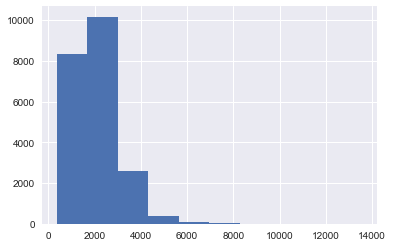

In [19]:
df.sqft_living.hist()

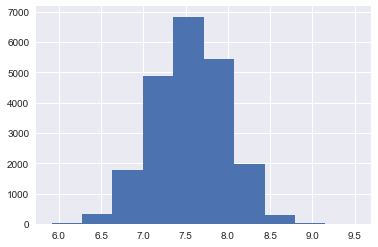

In [20]:
df.sqft_living = np.log(df.sqft_living)
df.sqft_living.hist()

Again, we performed a simple log-transformation to produce a normal distribution.

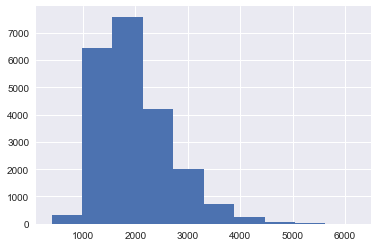

In [21]:
df.sqft_living15.hist()

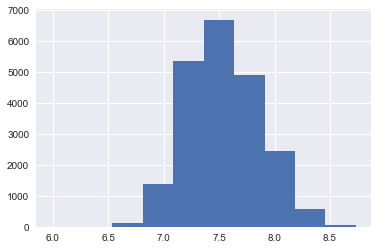

In [22]:
df.sqft_living15 = np.log(df.sqft_living15)
df.sqft_living15.hist()

Another log-transformation to normalize the distribution.

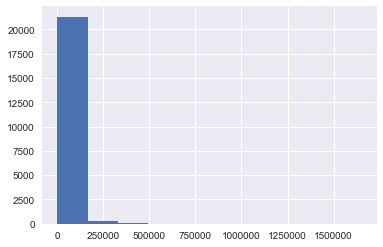

In [23]:
df.sqft_lot.hist()

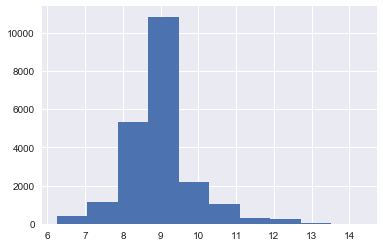

In [24]:
df.sqft_lot = np.log(df.sqft_lot)
df.sqft_lot.hist()

We log-transformed this column too.

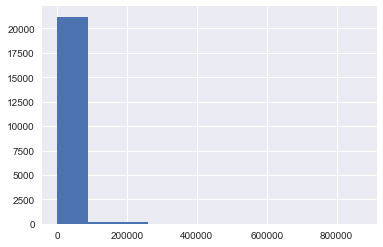

In [25]:
df.sqft_lot15.hist()

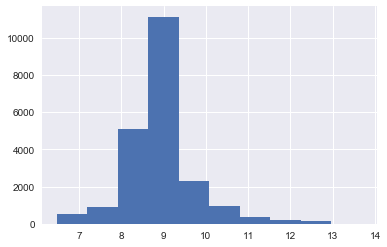

In [26]:
df.sqft_lot15 = np.log(df.sqft_lot15)
df.sqft_lot15.hist()

One more log-transformation to normalize the distribution.

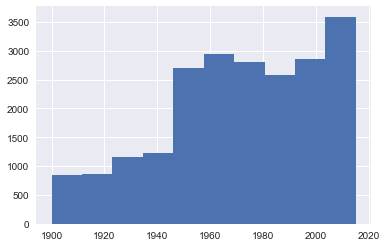

In [27]:
df.yr_built.hist()

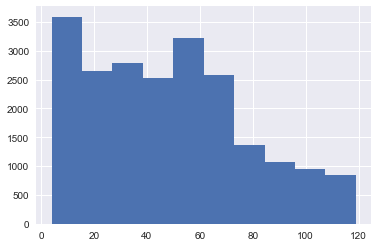

In [28]:
df['age'] = 2019 - df.yr_built
df.drop(['yr_built'], axis=1, inplace=True)
df.age.hist()

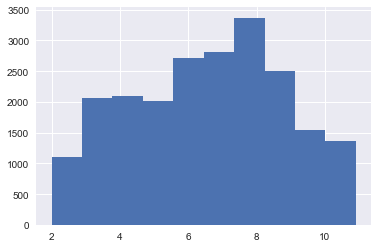

In [29]:
df.age = np.sqrt(df.age)
df.age.hist()

I felt that age would be a more intuitive predictor than yr_built, so we subtracted yr_built from 2019 to create an age column.  Then we square root transformed the column to create a normal distribution.  The log-transformation was not as effective in this case.

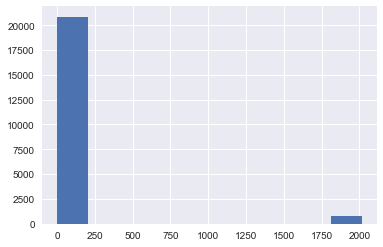

In [30]:
df.yr_renovated.hist()

In [31]:
df['renovated'] = df.yr_renovated.map(lambda x: 0 if x == 0 else 1)
df.drop('yr_renovated', axis=1, inplace=True)
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,zipcode,sqft_living15,sqft_lot15,basement,age,renovated
0,221900.0,3,0.000000,7.073270,8.639411,1.0,0.0,0.0,3,7,7.073270,98178,7.200425,8.639411,0,8.000000,0
1,538000.0,3,0.810930,7.851661,8.887653,2.0,0.0,0.0,3,7,7.682482,98125,7.432484,8.941022,1,8.246211,1
2,180000.0,2,0.000000,6.646391,9.210340,1.0,0.0,0.0,3,6,6.646391,98028,7.908387,8.994917,0,9.273618,0
3,604000.0,4,1.098612,7.580700,8.517193,1.0,0.0,0.0,5,7,6.956545,98136,7.215240,8.517193,1,7.348469,0
4,510000.0,3,0.693147,7.426549,8.997147,1.0,0.0,0.0,3,8,7.426549,98074,7.495542,8.923058,0,5.656854,0


Our yr_renovated column had an extreme number of zero values which skews the data.  We will replace it with a column that states whether the house has been renovated.

## Which Features Influence Price the Most by Themselves?

Now that our data is cleaned up, let's look at the relationship between our predictors and price.  

/Users/rlathbury/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


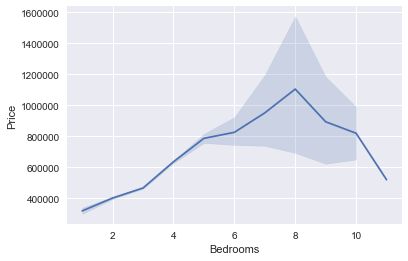

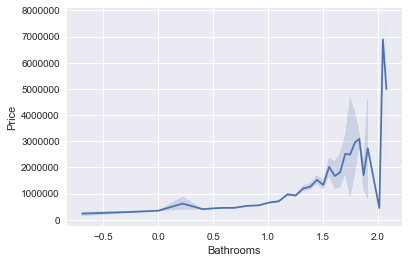

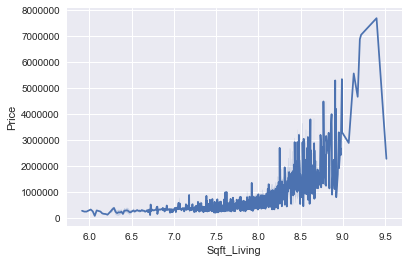

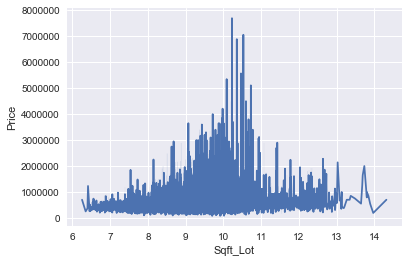

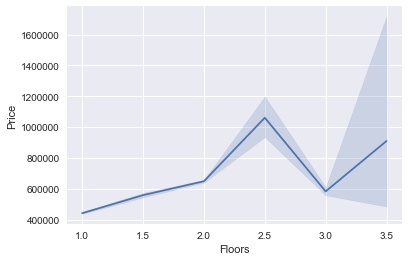

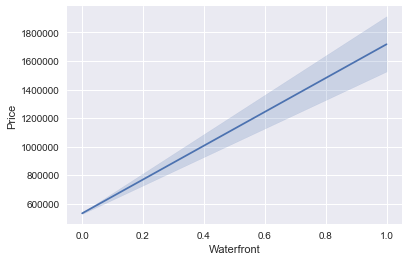

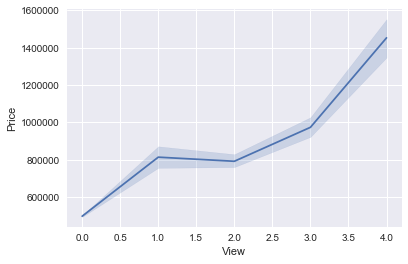

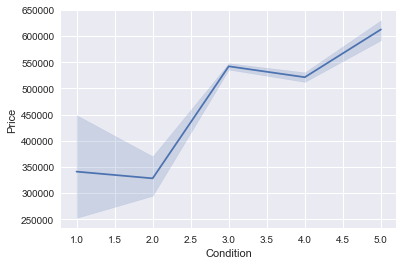

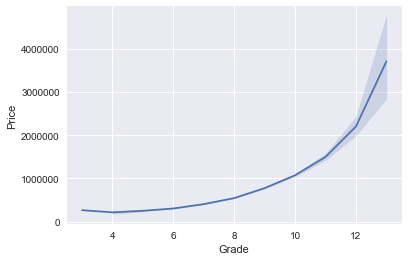

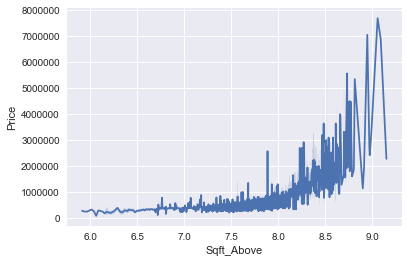

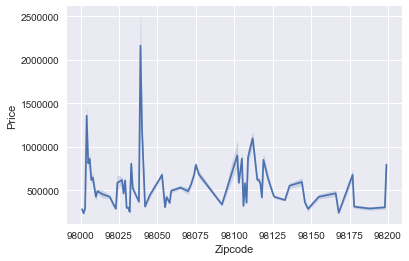

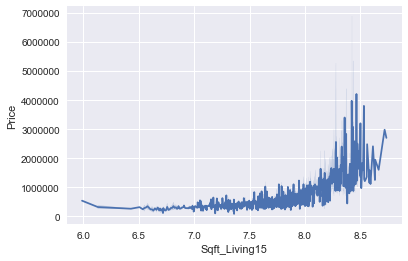

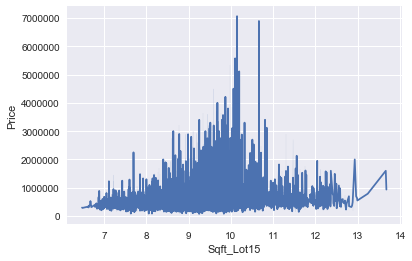

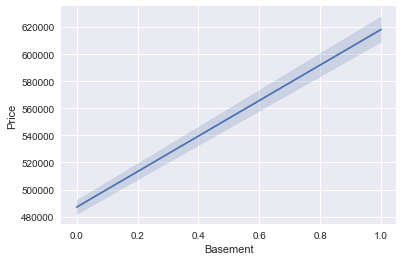

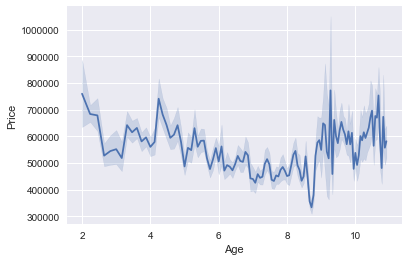

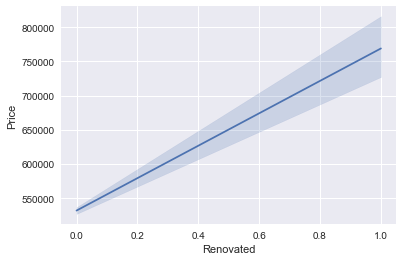

In [32]:
predictors = df.drop('price', axis=1)
for predictor in predictors:
    sns.lineplot(df[predictor], df.price)
    plt.xlabel(predictor.title())
    plt.ylabel('Price')
    
    plt.show()

It looks like several of our predictors correlate with price, most notably sqft_living, waterfront, view, condition, grade, basement, and renovated.

## How Similar are Houses to their Neighbors?

Neighborhoods tend to have very similar houses within them.  Here we will investigate the relationship between sqft_living and sqft_living15 as well as the relationship between sqft_lot and sqft_lot15.

Text(0.5, 1.0, 'Sq. Footage of Living Space of Home vs. Closest Neighbors')

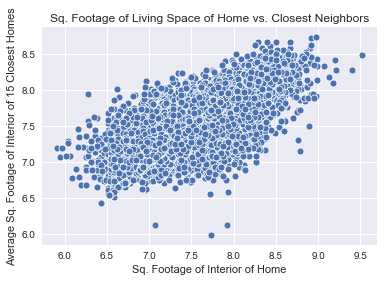

In [33]:
sns.scatterplot(df.sqft_living, df.sqft_living15)
plt.xlabel('Sq. Footage of Interior of Home')
plt.ylabel('Average Sq. Footage of Interior of 15 Closest Homes')
plt.title('Sq. Footage of Living Space of Home vs. Closest Neighbors')

There is a noticeable pattern between the living spaces of a home and the living spaces of its neighbors, though it is not as strong as I initially thought.  Let's look at landsize.

Text(0.5, 1.0, 'Sq. Footage of Land Lot of Home vs. Closest Neighbors')

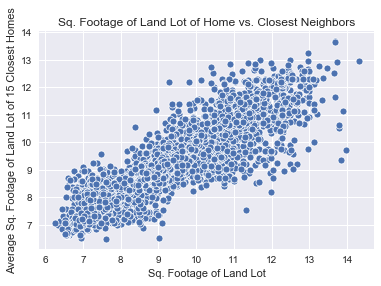

In [34]:
sns.scatterplot(df.sqft_lot, df.sqft_lot15)
plt.xlabel('Sq. Footage of Land Lot')
plt.ylabel('Average Sq. Footage of Land Lot of 15 Closest Homes')
plt.title('Sq. Footage of Land Lot of Home vs. Closest Neighbors')

It seems that there is a very strong linear relationship between lot sizes of a home and its neighbors.  This makes sense as neighborhoods tend to be divided into similar sized land plots.

## How Does Waterfront Relate to View?

Having a home on the waterfront seems like it would provide an excellent view.  Let's check the relationship between these variables.

Text(0.5, 1.0, 'View Without Waterfront')

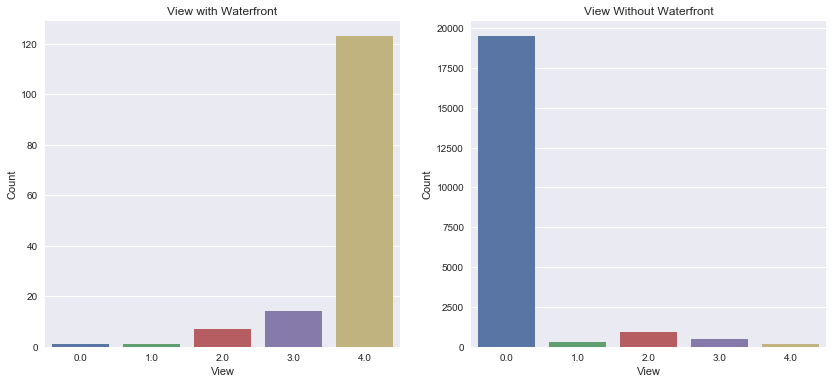

In [35]:
df_waterfront = df[df.waterfront == 1]
df_nowaterfront = df[df.waterfront == 0]
fig = plt.figure(figsize = (14,6))
plt.title('View by Waterfront')
plt.subplot(121)
sns.countplot(df_waterfront.view)
plt.xlabel('View')
plt.ylabel('Count')
plt.title('View with Waterfront')
plt.subplot(122)
sns.countplot(df_nowaterfront.view)
plt.xlabel('View')
plt.ylabel('Count')
plt.title('View Without Waterfront')

As expected, homes that are on a waterfront have a much higher proportion of better views.  The majority of homes on the waterfront have 4.0 rated views, while the majority of homes not on the water have a 0.0 rated view.

## Fixing our Zip code Data

Let's get back to our zip code data now.  In order to make this information able to be modeled we will change the column's datatype to category and get dummies for our data.  We will also drop a column of zip code data so our model has fewer multicollinearity issues.  Before changing the zip code column we will make a copy of our data so we can return to this point if we need to.

In [36]:
data = df
print(data.zipcode.unique())
data.zipcode = data.zipcode.astype('category')

[98178 98125 98028 98136 98074 98053 98003 98198 98146 98038 98007 98115
 98107 98126 98019 98103 98002 98133 98040 98092 98030 98119 98112 98052
 98027 98117 98058 98001 98056 98166 98023 98070 98148 98105 98042 98008
 98059 98122 98144 98004 98005 98034 98075 98116 98010 98118 98199 98032
 98045 98102 98077 98108 98168 98177 98065 98029 98006 98109 98022 98033
 98155 98024 98011 98031 98106 98072 98188 98014 98055 98039]


In [37]:
data = pd.get_dummies(data)
data = data.drop(['zipcode_98001'], axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21596 entries, 0 to 21596
Data columns (total 85 columns):
price            21596 non-null float64
bedrooms         21596 non-null int64
bathrooms        21596 non-null float64
sqft_living      21596 non-null float64
sqft_lot         21596 non-null float64
floors           21596 non-null float64
waterfront       21596 non-null float64
view             21596 non-null float64
condition        21596 non-null int64
grade            21596 non-null int64
sqft_above       21596 non-null float64
sqft_living15    21596 non-null float64
sqft_lot15       21596 non-null float64
basement         21596 non-null int64
age              21596 non-null float64
renovated        21596 non-null int64
zipcode_98002    21596 non-null uint8
zipcode_98003    21596 non-null uint8
zipcode_98004    21596 non-null uint8
zipcode_98005    21596 non-null uint8
zipcode_98006    21596 non-null uint8
zipcode_98007    21596 non-null uint8
zipcode_98008    21596 non-null u

## Modeling the Data

Now it is time to start modeling.  First we will test multicollinearity in our model.  Then, are going to run a stepwise selection process to trim our dataset down to columns with a p-value lower than 0.05.  Next we will run a series of recursive feature eliminations to determine our most accurate model while using a test-train split with a test size of 0.20.  Finally we will run a cross validation to check the validity of our model.

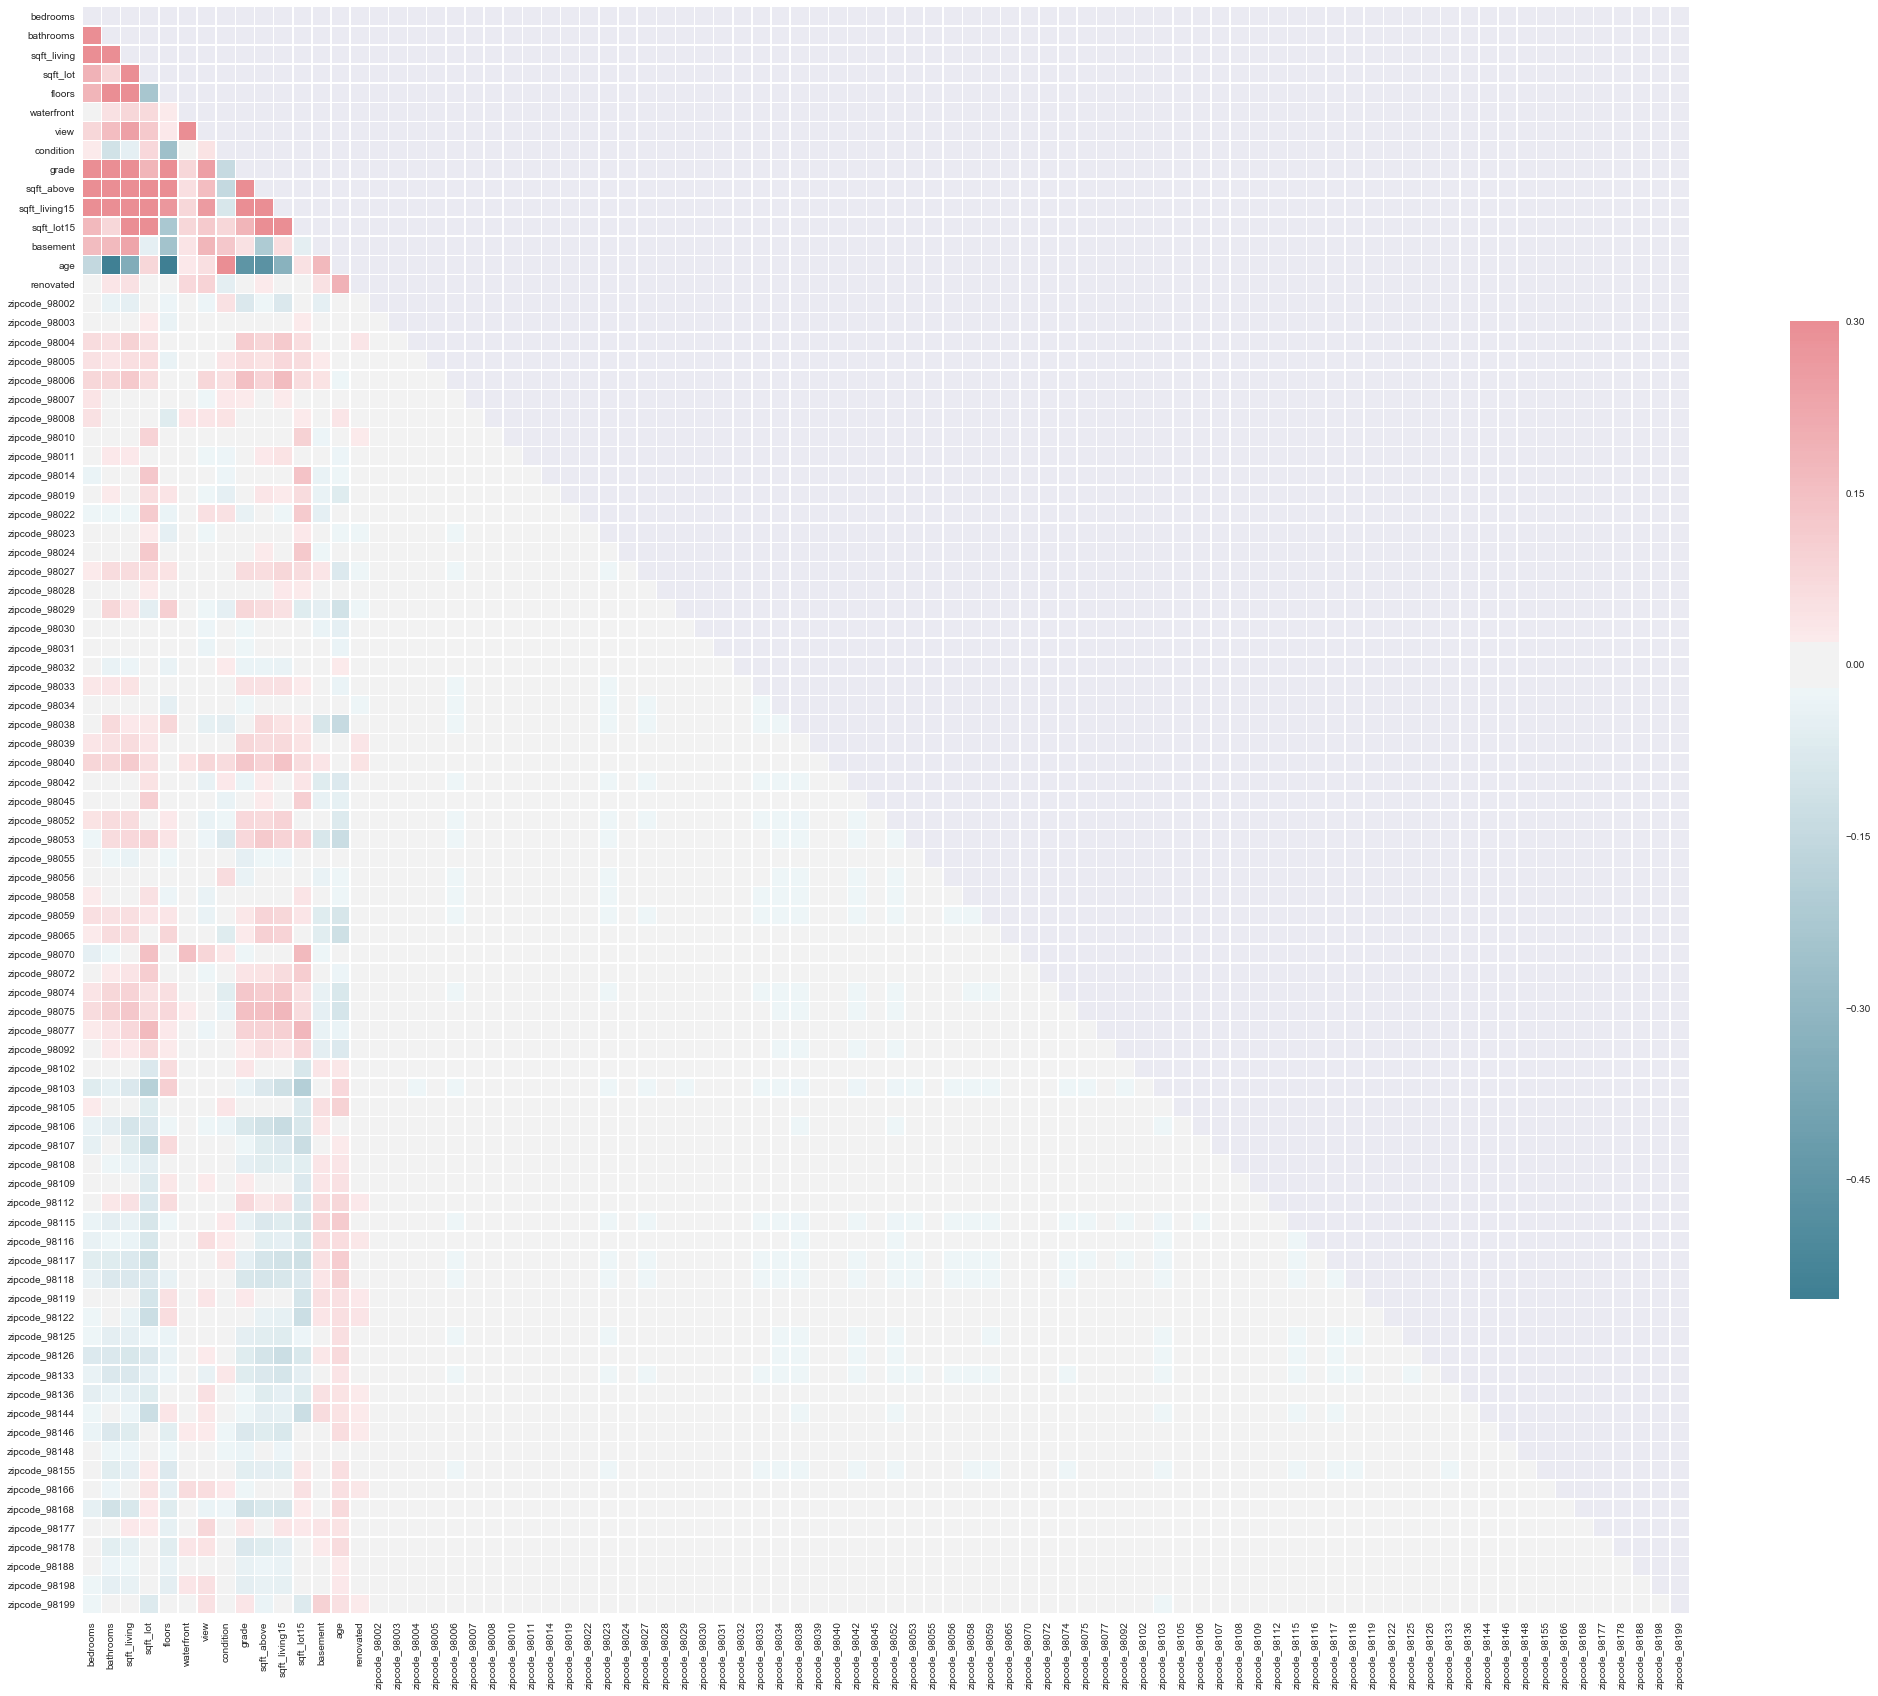

In [38]:
# Next we will check multicollinearity by creating a correlation heat map.
# Now we will run an OLS to check p-values and r-squared for our current model.
X = data.drop('price', axis=1)
y = data.price

corr = X.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(36, 36))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

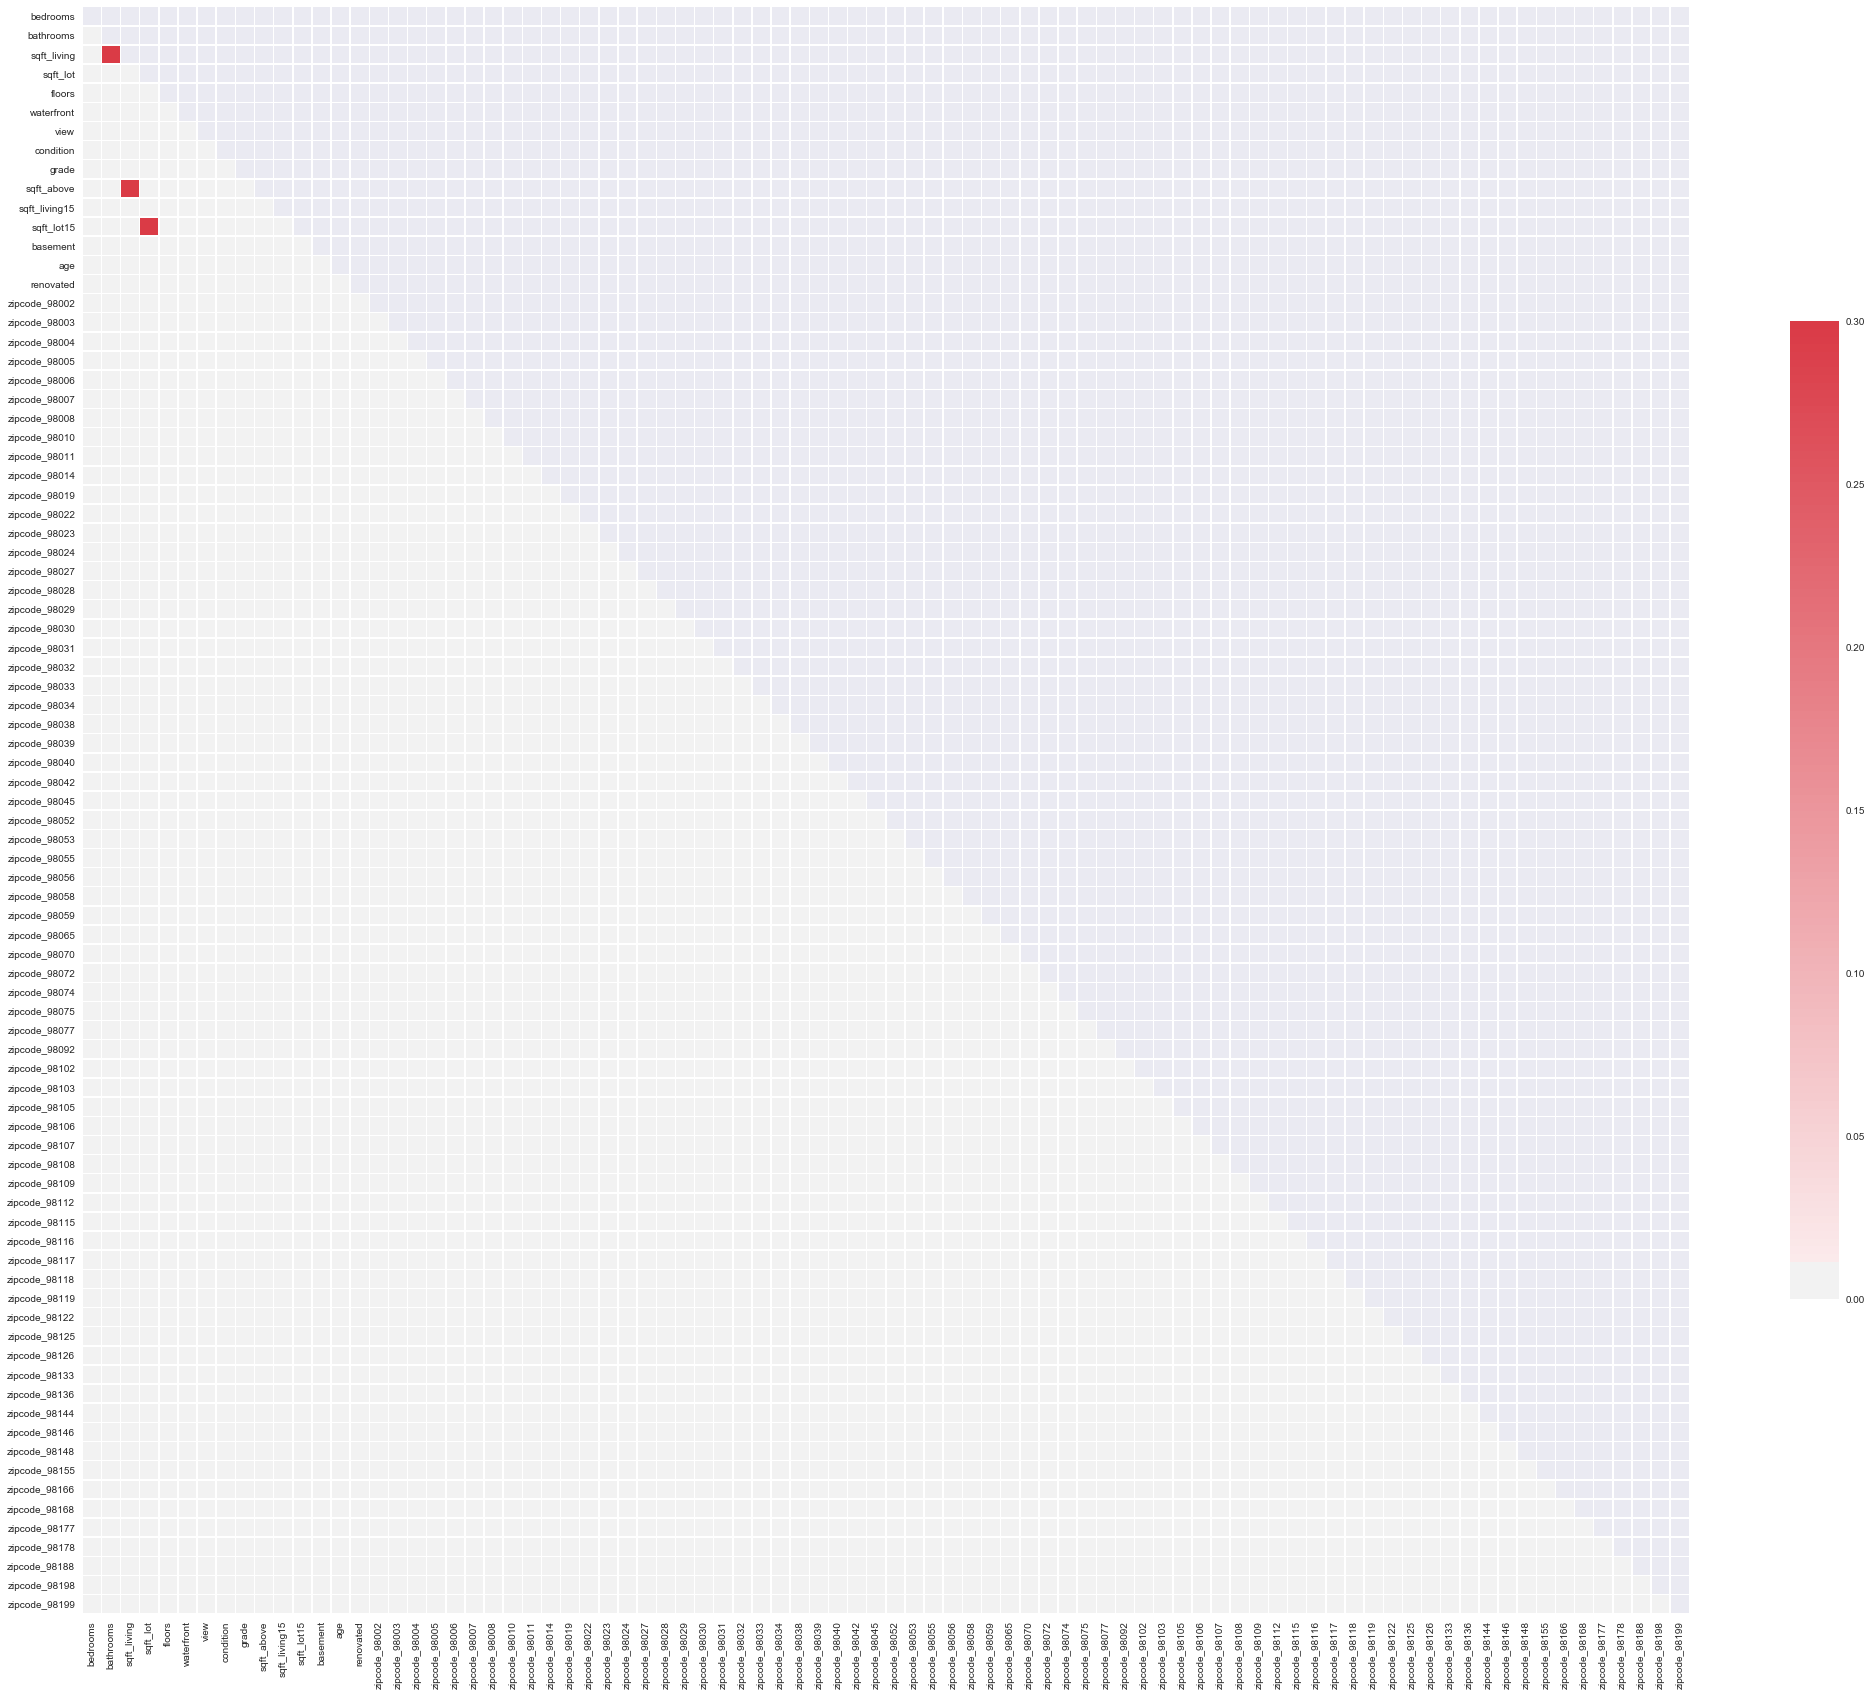

In [39]:
# We definitely have some patches of multicollinearity.  Let's set a limit of 0.75 and drop columns from intersections
# that are higher than that.
corr = abs(X.corr()) >= 0.75
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(36, 36))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [40]:
# We have three intersections that are higher than 0.75.  Two of these spots involve sqft_living, so we will drop that
# column.  The third troubling spot is between sqft_lot15 and sqft_lot.  Of these two, sqft_lot15 has more 
# multicollinearity among other variables.  We will drop it.
X.drop(['sqft_living', 'sqft_lot15'], axis = 1, inplace=True)
X.head()

,bedrooms,bathrooms,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_living15,...,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
0,3,0.000000,8.639411,1.0,0.0,0.0,3,7,7.073270,7.200425,...,0,0,0,0,0,0,1,0,0,0
1,3,0.810930,8.887653,2.0,0.0,0.0,3,7,7.682482,7.432484,...,0,0,0,0,0,0,0,0,0,0
2,2,0.000000,9.210340,1.0,0.0,0.0,3,6,6.646391,7.908387,...,0,0,0,0,0,0,0,0,0,0
3,4,1.098612,8.517193,1.0,0.0,0.0,5,7,6.956545,7.215240,...,0,0,0,0,0,0,0,0,0,0
4,3,0.693147,8.997147,1.0,0.0,0.0,3,8,7.426549,7.495542,...,0,0,0,0,0,0,0,0,0,0


In [41]:
# Here we will define a stepwise selector function which will weed out factors with a p-value higher than 0.05.
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included


included_col = stepwise_selection(X,y)
print(len(included_col))

Add  sqft_above                     with p-value 0.0
Add  zipcode_98004                  with p-value 0.0
Add  sqft_living15                  with p-value 0.0
Add  waterfront                     with p-value 0.0
Add  basement                       with p-value 0.0
Add  grade                          with p-value 0.0
Add  age                            with p-value 0.0
Add  zipcode_98039                  with p-value 3.4832e-293
Add  view                           with p-value 5.1998e-172
Add  zipcode_98112                  with p-value 1.03818e-153
Add  zipcode_98040                  with p-value 1.67461e-146
Drop sqft_living15                  with p-value 0.283454


/Users/rlathbury/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:44: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.


Add  zipcode_98023                  with p-value 4.40971e-101
Add  zipcode_98033                  with p-value 4.40872e-94
Add  zipcode_98105                  with p-value 1.55091e-62
Add  zipcode_98092                  with p-value 4.36336e-59
Add  zipcode_98003                  with p-value 8.89923e-55
Add  zipcode_98103                  with p-value 4.57788e-49
Add  zipcode_98115                  with p-value 4.65971e-53
Add  zipcode_98119                  with p-value 1.04466e-52
Add  zipcode_98199                  with p-value 2.52705e-55
Add  zipcode_98117                  with p-value 2.80015e-57
Add  zipcode_98102                  with p-value 1.86878e-48
Add  zipcode_98109                  with p-value 4.92278e-49
Add  zipcode_98006                  with p-value 3.78928e-47
Add  zipcode_98107                  with p-value 2.83553e-44
Add  zipcode_98042                  with p-value 8.87947e-38
Add  zipcode_98198                  with p-value 2.36847e-34
Add  zipcode_98058     

In [42]:
X = X[included_col]
X.head()

,sqft_above,zipcode_98004,waterfront,basement,grade,age,zipcode_98039,view,zipcode_98112,zipcode_98040,...,zipcode_98028,zipcode_98056,zipcode_98011,zipcode_98024,zipcode_98168,zipcode_98059,zipcode_98077,bathrooms,zipcode_98014,zipcode_98019
0,7.073270,0,0.0,0,7,8.000000,0,0.0,0,0,...,0,0,0,0,0,0,0,0.000000,0,0
1,7.682482,0,0.0,1,7,8.246211,0,0.0,0,0,...,0,0,0,0,0,0,0,0.810930,0,0
2,6.646391,0,0.0,0,6,9.273618,0,0.0,0,0,...,1,0,0,0,0,0,0,0.000000,0,0
3,6.956545,0,0.0,1,7,7.348469,0,0.0,0,0,...,0,0,0,0,0,0,0,1.098612,0,0
4,7.426549,0,0.0,0,8,5.656854,0,0.0,0,0,...,0,0,0,0,0,0,0,0.693147,0,0


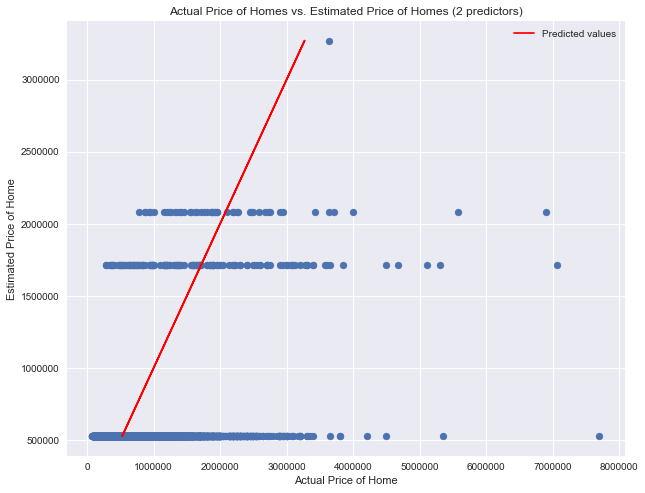

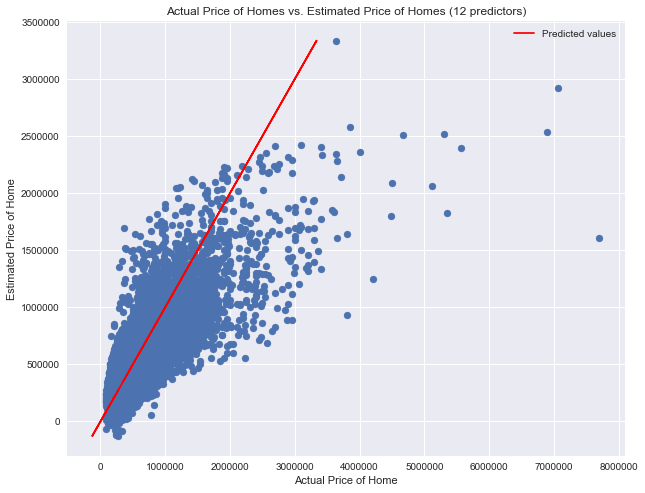

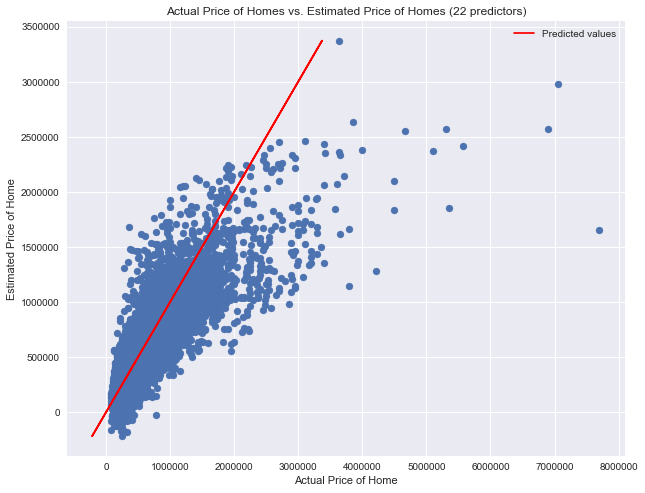

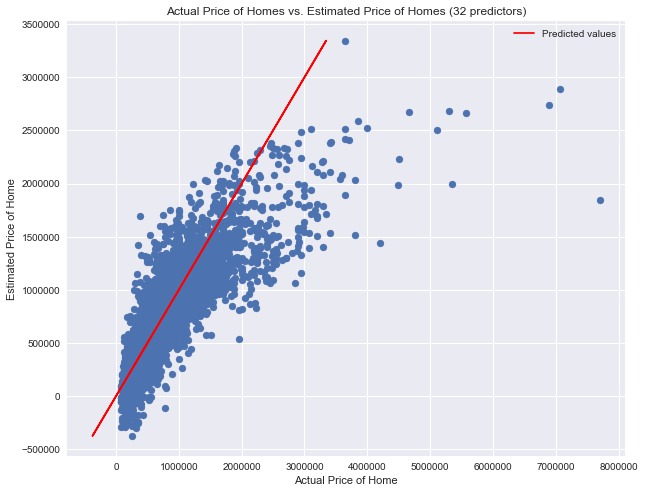

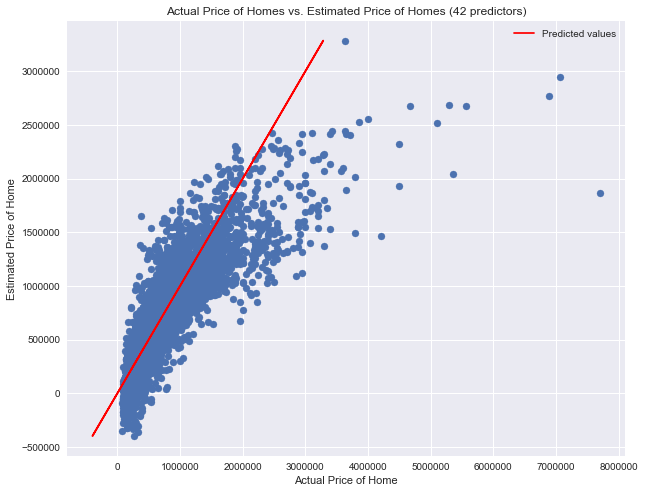

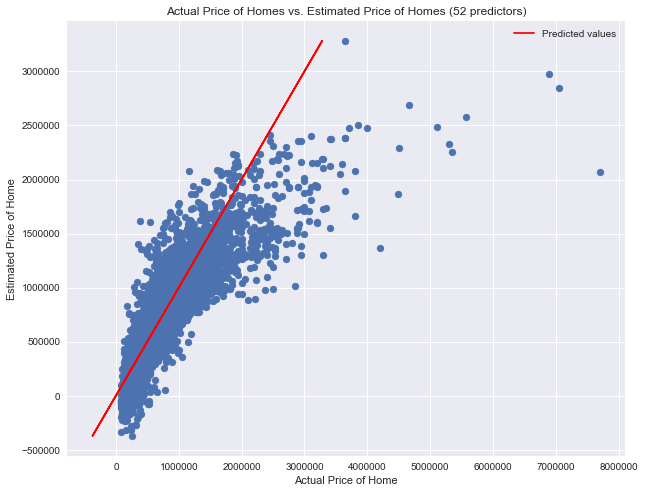

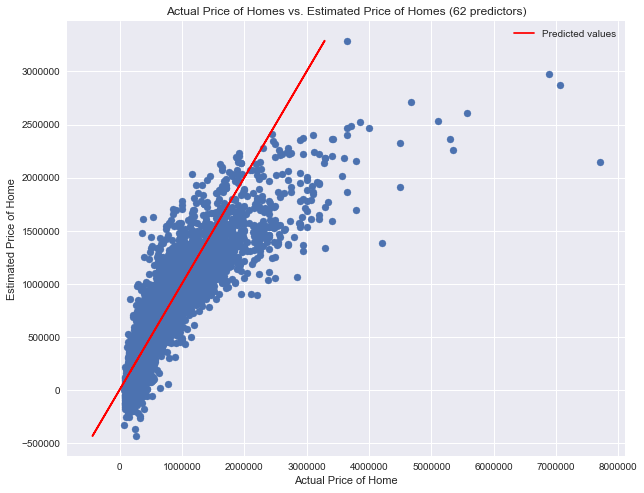

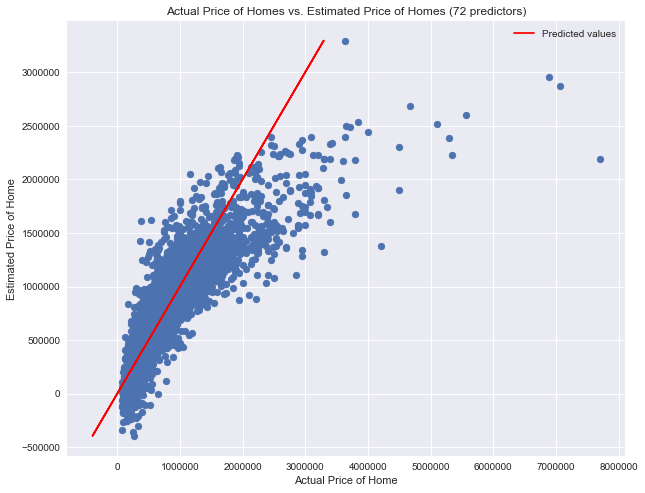

[121180569202.20412, 62694460941.07873, 52764637627.044914, 41380857196.76843, 37905123743.37131, 34538631746.86178, 32579390550.213444, 32101036932.89056]
[113065685675.57175, 59395681266.735275, 49493374700.96963, 38313975132.46191, 35069877059.72118, 32131372751.369373, 30072931613.404633, 29492172709.997757]
[8114883526.63237, 3298779674.3434525, 3271262926.075287, 3066882064.306526, 2835246683.6501236, 2407258995.492405, 2506458936.808811, 2608864222.892803]


In [43]:
# Here we will run a series of recursive feature eliminations with increasingly larger numbers of features to include.
# We will start by setting up some empty lists and setting a test-train split.
mse_trains = []
mse_tests = []
mse_diff = []
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.2)

# Next we will iterate over a list of numbers which represent the number of features we will include in each iteration.
# For each iteration we will define the model, calculate errors, and plot a scatter plot of how the model applies to
# the entirty of the data.
for n in list(range(2, 73, 10)):
    # We define the model:
    linereg = LinearRegression()
    select_n = RFE(linereg, n_features_to_select = n)
    select_n = select_n.fit(X_train, np.ravel(y_train))
    selected_columns = X.columns[select_n.support_ ]
    linereg.fit(X_train[selected_columns],y_train)
    
    #We calculate errors:
    yhat_train = linereg.predict(X_train[selected_columns])
    yhat_test = linereg.predict(X_test[selected_columns])
    yhat = linereg.predict(X[selected_columns])
    mse_train = mean_squared_error(yhat_train, y_train)
    mse_test = mean_squared_error(yhat_test, y_test)
    mse_trains.append(mse_train)
    mse_tests.append(mse_test)
    mse_diff.append(mse_train - mse_test)
    
    # We plot the actual price of each house against the predicted price:
    plt.figure(figsize = (10,8))
    plt.scatter(y, yhat)
    plt.plot(yhat, yhat, color='red', label='Predicted values')
    plt.xlabel('Actual Price of Home')
    plt.ylabel('Estimated Price of Home')
    plt.title(f'Actual Price of Homes vs. Estimated Price of Homes ({n} predictors)')
    plt.legend()
    plt.show()
print(mse_trains)
print(mse_tests)
print(mse_diff)

In [44]:
# Now we will run an OLS to check coefficients and r-squared for our current model.
X_int = sm.add_constant(X)
model = sm.OLS(y, X_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.766
Model:                            OLS   Adj. R-squared:                  0.765
Method:                 Least Squares   F-statistic:                     979.7
Date:                Mon, 29 Jul 2019   Prob (F-statistic):               0.00
Time:                        12:43:11   Log-Likelihood:            -2.9168e+05
No. Observations:               21596   AIC:                         5.835e+05
Df Residuals:                   21523   BIC:                         5.841e+05
Df Model:                          72                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -2.797e+06   4.51e+04    -61.965      0.000   -2.89e+06   -2.71e+06
sqft_above     2.436e+05   6409.757     38.001      0.000    2.31e+05    2.56e+05
zipcode_98004  7.632e+05   1.09e+04     70.017      0.000    7.42e+05    7.85e+05
waterfront     7.171e+05   1.62e+04     44.173      0.000    6.85e+05    7.49e+05
basement       5.067e+04   3243.934     15.619      0.000    4.43e+04     5.7e+04
grade          9.617e+04   1923.891     49.988      0.000    9.24e+04    9.99e+04
age            5464.8271    965.466      5.660      0.000    3572.441    7357.213
zipcode_98039  1.373e+06   2.57e+04     53.515      0.000    1.32e+06    1.42e+06
view            6.65e+04   1895.107     35.092      0.000    6.28e+04    7.02e+04
zipcode_98112  6.179e+05   1.22e+04     50.517      0.000    5.94e+05    6.42e+05
zipcode_98040  4.877e+05   1.16e+04     42.161      0.000    4.65e+05     5.1e+05
zipcode_98023 -8.333e+04   8781.176     -9.490      0.000   -1.01e+05   -6.61e+04
zipcode_98033  3.314e+05   9383.204     35.320      0.000    3.13e+05     3.5e+05
zipcode_98105  4.535e+05   1.29e+04     35.248      0.000    4.28e+05    4.79e+05
zipcode_98092 -9.907e+04   1.02e+04     -9.700      0.000   -1.19e+05    -7.9e+04
zipcode_98003 -7.046e+04   1.13e+04     -6.262      0.000   -9.25e+04   -4.84e+04
zipcode_98103  3.287e+05   8850.892     37.141      0.000    3.11e+05    3.46e+05
zipcode_98115   3.17e+05   8676.418     36.540      0.000       3e+05    3.34e+05
zipcode_98119  4.562e+05   1.42e+04     32.044      0.000    4.28e+05    4.84e+05
zipcode_98199  3.682e+05   1.11e+04     33.170      0.000    3.46e+05     3.9e+05
zipcode_98117  3.111e+05   8910.001     34.916      0.000    2.94e+05    3.29e+05
zipcode_98102  5.078e+05   1.84e+04     27.572      0.000    4.72e+05    5.44e+05
zipcode_98109  4.832e+05   1.79e+04     26.967      0.000    4.48e+05    5.18e+05
zipcode_98006  2.371e+05   9101.773     26.051      0.000    2.19e+05    2.55e+05
zipcode_98107  3.353e+05    1.2e+04     27.887      0.000    3.12e+05    3.59e+05
zipcode_98042 -4.203e+04   8460.493     -4.968      0.000   -5.86e+04   -2.54e+04
zipcode_98198 -4.216e+04   1.13e+04     -3.738      0.000   -6.43e+04   -2.01e+04
zipcode_98058 -2.207e+04   9114.472     -2.421      0.015   -3.99e+04   -4203.787
zipcode_98122  3.188e+05   1.17e+04     27.240      0.000    2.96e+05    3.42e+05
zipcode_98144  2.816e+05   1.07e+04     26.201      0.000     2.6e+05    3.03e+05
zipcode_98116  2.743e+05   1.09e+04     25.217      0.000    2.53e+05    2.96e+05
sqft_lot       3.808e+04   2028.417     18.775      0.000    3.41e+04    4.21e+04
zipcode_98022 -7.991e+04   1.23e+04     -6.472      0.000   -1.04e+05   -5.57e+04
zipcode_98030 -4.602e+04   1.17e+04     -3.932      0.000    -6.9e+04   -2.31e+04
zipcode_98031 -3.634e+04   1.14e+04     -3.194   

In [45]:
# Finally, we perform a cross validation looking at mean squared errors and r-squared values as scores
cv_nmse = cross_val_score(linereg, X[selected_columns], y, cv=10, scoring="neg_mean_squared_error")

cv_r_squared = cross_val_score(linereg, X[selected_columns], y, cv=10, scoring="r2")
cv_nmse, cv_r_squared

(array([-3.67087085e+10, -3.86285452e+10, -2.72802022e+10, -4.77648934e+10,
        -2.81155596e+10, -2.74815294e+10, -2.60363521e+10, -2.60676040e+10,
        -3.19761100e+10, -3.14089950e+10]),
 array([0.7463064 , 0.75618099, 0.76540266, 0.70964193, 0.74457053,
        0.77809135, 0.78791991, 0.80183005, 0.76332371, 0.77381043]))

## Analysis

Multicollinearity was a problem for us.  We ended up deciding that any correlation above 0.75 was too much multicollinearity for our model.  This meant that we had to drop two predictors from our dataset.  Once our multicollinearity was addressed, we ran a stepwise selector to find our best p-values.  The stepwise selection showed 72 features with a p-value less than 0.05.  Next, we ran a series of RFE's using subsets of those features looking for the model with the best fit.  These models contained between 2 and 72 predictors, with each new model containing 10 more features than the last.  As the number of predictors increased, the error values fell indicating that each new model was more accurate than the previous one.  The difference in errors between the testing and training sets was fairly consistent which shows that the model is also not overfitting the training data.  Because of the error values, we will use the model with all 72 predictors.  Next we ran our model using OLS from statsmodels.  This presented us with a handy list of metrics about our model.  Finally, a cross validation was run to determine mean squared errors and r-squared values.  Both the mean squared errors and r-squared values are fairly consistent, showing a reasonable goodness of fit.  

Now, let's discuss the results of our model.  Our strongest predictor was zipcode_98039 with a coefficient of 1.373e+06.  According to our data, having the area code 98039 was the single strongest attribute for increasing the value of the home.  Our strongest negative predictor was zipcode_98092 with a coefficient of -9.907e+04.  This zip code had the strongest effect on lowering the value of a home.	The least impactful predictor was age with a coefficient of 5464.8271.  Overall the model does a decent job predicting house values with an r-squared rating of .766, but does not seem to accurately predict a house's price when the price is extremely high.  Next, we will look at some possibilities of how we might refine our model.

## How Does the Model Change When We Set a Price Cap?

While forming our model, I did not want to remove the more expensive houses from the dataset.  Initially, I wanted as much data as possible to form an accurate model.  However, now that our model has shown that extremely expensive houses are difficult to predict with our data, we should see if we can produce a more useful model by limiting the price of houses we are trying to predict.  For example, we may be able to reliably target a wider demographic of property purchasers by not focusing our model on expensive homes.

Looking at the scatterplots of our model, Accuracy seems to decrease when price exceeds 3,000,000.  Let's see how accurate our model becomes when we exclude those houses.

In [46]:
data_cap = data[data.price <= 3000000]
len(data_cap)

21551

In [47]:
X_cap = data_cap.drop('price', axis=1)
y_cap = data_cap.price
included_col = stepwise_selection(X_cap,y_cap)
print(len(included_col))
X_cap = X_cap[included_col]
X_cap.head()

Add  sqft_above                     with p-value 0.0
Add  zipcode_98004                  with p-value 0.0
Add  sqft_living15                  with p-value 0.0
Add  sqft_living                    with p-value 0.0
Drop sqft_above                     with p-value 0.874965


/Users/rlathbury/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:44: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.


Add  grade                          with p-value 0.0
Add  age                            with p-value 0.0
Add  view                           with p-value 0.0
Add  zipcode_98039                  with p-value 1.13876e-200
Add  zipcode_98112                  with p-value 7.11559e-198
Add  zipcode_98040                  with p-value 8.46541e-157
Add  zipcode_98023                  with p-value 5.39636e-121
Add  waterfront                     with p-value 1.4002e-119
Add  zipcode_98033                  with p-value 6.09319e-111
Add  sqft_lot15                     with p-value 3.85649e-104
Add  zipcode_98105                  with p-value 4.1737e-71
Add  zipcode_98092                  with p-value 6.11857e-65
Add  zipcode_98003                  with p-value 5.02267e-67
Add  zipcode_98042                  with p-value 5.34346e-56
Add  zipcode_98058                  with p-value 4.15729e-56
Add  zipcode_98198                  with p-value 1.3284e-53
Add  zipcode_98119                  with p-v

,zipcode_98004,sqft_living15,sqft_living,grade,age,view,zipcode_98039,zipcode_98112,zipcode_98040,zipcode_98023,...,zipcode_98168,zipcode_98014,zipcode_98019,zipcode_98166,zipcode_98045,zipcode_98178,sqft_lot15,zipcode_98055,zipcode_98148,zipcode_98010
0,0,7.200425,7.073270,7,8.000000,0.0,0,0,0,0,...,0,0,0,0,0,1,8.639411,0,0,0
1,0,7.432484,7.851661,7,8.246211,0.0,0,0,0,0,...,0,0,0,0,0,0,8.941022,0,0,0
2,0,7.908387,6.646391,6,9.273618,0.0,0,0,0,0,...,0,0,0,0,0,0,8.994917,0,0,0
3,0,7.215240,7.580700,7,7.348469,0.0,0,0,0,0,...,0,0,0,0,0,0,8.517193,0,0,0
4,0,7.495542,7.426549,8,5.656854,0.0,0,0,0,0,...,0,0,0,0,0,0,8.923058,0,0,0


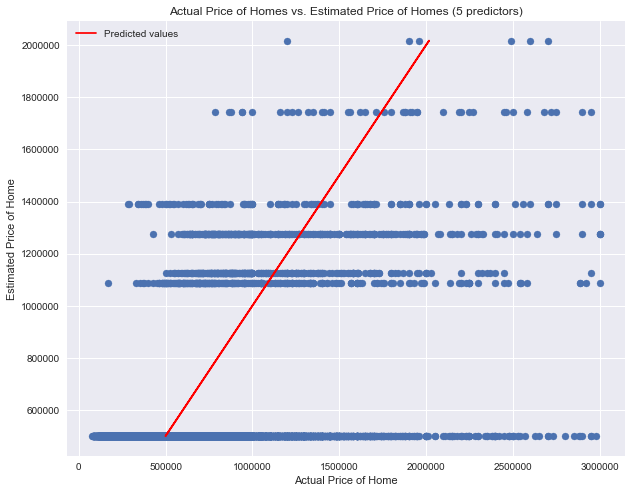

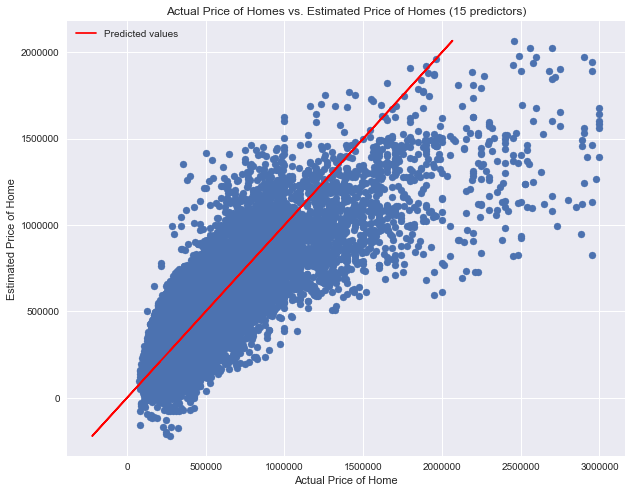

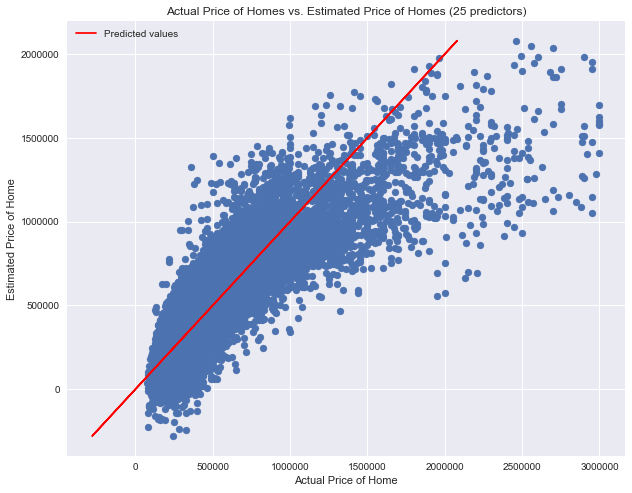

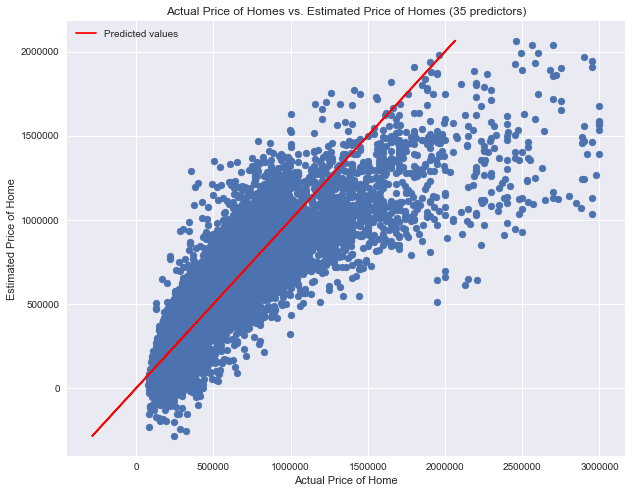

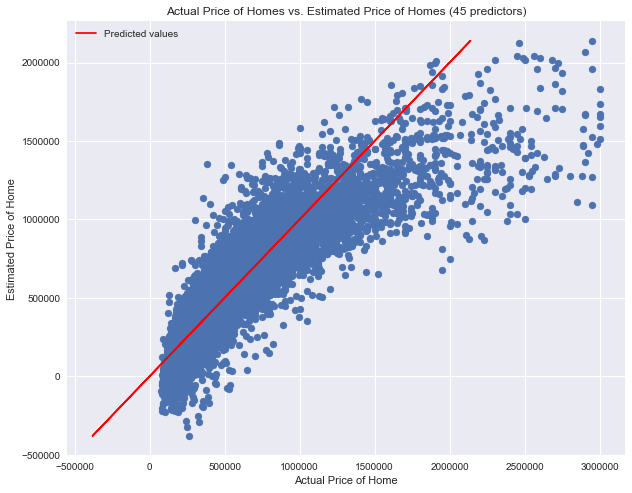

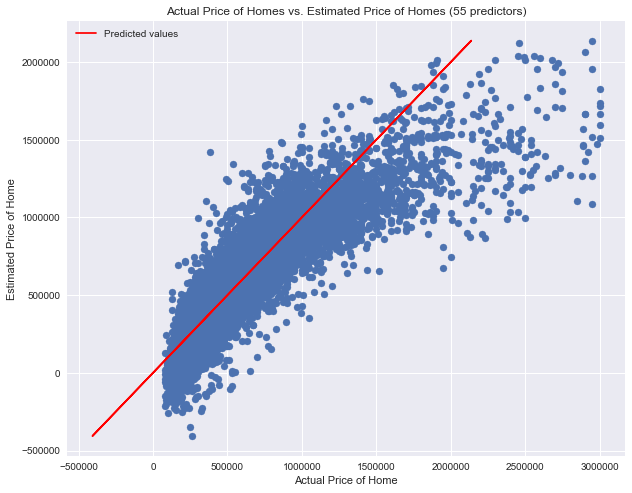

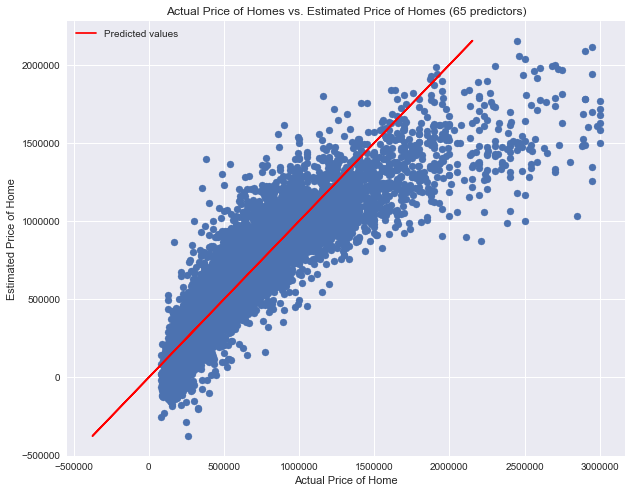

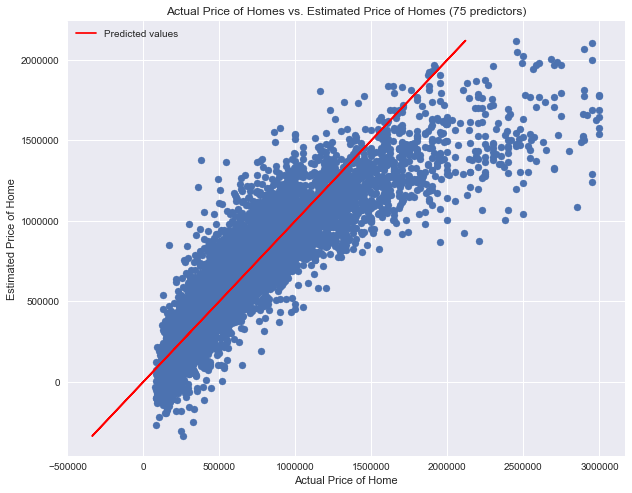

[83651958993.38098, 42562867180.700615, 36210777774.703545, 33065812717.77179, 27010040994.558468, 26258071779.01787, 22520800799.435246, 21935638780.02953]
[89160632318.47182, 45952119494.71795, 39247158179.38218, 36054824405.13344, 29181457287.542336, 28444989102.155777, 24338511844.289497, 23594784907.616856]


In [48]:
mse_trains = []
mse_tests = []
X_train, X_test, y_train, y_test = train_test_split(X_cap, y_cap, test_size =0.2)

for n in list(range(5, 76, 10)):
    linereg = LinearRegression()
    select_n = RFE(linereg, n_features_to_select = n)
    select_n = select_n.fit(X_train, np.ravel(y_train))
    selected_columns = X_cap.columns[select_n.support_ ]
    linereg.fit(X_train[selected_columns],y_train)
    
    yhat_train = linereg.predict(X_train[selected_columns])
    yhat_test = linereg.predict(X_test[selected_columns])
    yhat = linereg.predict(X_cap[selected_columns])
    mse_train = mean_squared_error(yhat_train, y_train)
    mse_test = mean_squared_error(yhat_test, y_test)
    mse_trains.append(mse_train)
    mse_tests.append(mse_test)
    
    plt.figure(figsize = (10,8))
    plt.scatter(y_cap, yhat)
    plt.plot(yhat, yhat, color='red', label='Predicted values')
    plt.xlabel('Actual Price of Home')
    plt.ylabel('Estimated Price of Home')
    plt.title(f'Actual Price of Homes vs. Estimated Price of Homes ({n} predictors)')
    plt.legend()
    plt.show()
print(mse_trains)
print(mse_tests)

In [49]:
X_int = sm.add_constant(X_cap)
model = sm.OLS(y_cap, X_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.796
Model:                            OLS   Adj. R-squared:                  0.795
Method:                 Least Squares   F-statistic:                     1117.
Date:                Mon, 29 Jul 2019   Prob (F-statistic):               0.00
Time:                        12:50:19   Log-Likelihood:            -2.8731e+05
No. Observations:               21551   AIC:                         5.748e+05
Df Residuals:                   21475   BIC:                         5.754e+05
Df Model:                          75                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -2.861e+06   3.75e+04    -76.386      0.000   -2.93e+06   -2.79e+06
zipcode_98004  7.375e+05   9239.507     79.820      0.000    7.19e+05    7.56e+05
sqft_living15  4.029e+04   5481.995      7.350      0.000    2.95e+04     5.1e+04
sqft_living    6.663e+04   9861.190      6.757      0.000    4.73e+04     8.6e+04
grade          8.446e+04   1638.091     51.559      0.000    8.12e+04    8.77e+04
age            3564.6331    780.161      4.569      0.000    2035.460    5093.806
view           6.291e+04   1599.973     39.322      0.000    5.98e+04     6.6e+04
zipcode_98039  1.143e+06   2.31e+04     49.379      0.000     1.1e+06    1.19e+06
zipcode_98112  6.406e+05   1.03e+04     62.053      0.000     6.2e+05    6.61e+05
zipcode_98040  5.029e+05   9769.381     51.482      0.000    4.84e+05    5.22e+05
zipcode_98023 -5.288e+04   7347.852     -7.197      0.000   -6.73e+04   -3.85e+04
waterfront     4.787e+05   1.45e+04     33.069      0.000     4.5e+05    5.07e+05
zipcode_98033  3.559e+05   7865.910     45.240      0.000     3.4e+05    3.71e+05
zipcode_98105  4.827e+05   1.09e+04     44.474      0.000    4.61e+05    5.04e+05
zipcode_98092 -6.863e+04   8548.617     -8.028      0.000   -8.54e+04   -5.19e+04
zipcode_98003 -4.072e+04   9432.379     -4.317      0.000   -5.92e+04   -2.22e+04
zipcode_98042 -1.682e+04   7064.576     -2.381      0.017   -3.07e+04   -2970.208
zipcode_98119  4.808e+05    1.2e+04     40.015      0.000    4.57e+05    5.04e+05
zipcode_98115  3.425e+05   7317.807     46.807      0.000    3.28e+05    3.57e+05
zipcode_98199  3.958e+05   9360.074     42.281      0.000    3.77e+05    4.14e+05
zipcode_98103  3.502e+05   7491.263     46.750      0.000    3.36e+05    3.65e+05
zipcode_98117  3.352e+05   7520.946     44.566      0.000     3.2e+05     3.5e+05
zipcode_98109   4.99e+05   1.51e+04     32.961      0.000    4.69e+05    5.29e+05
zipcode_98107   3.58e+05   1.01e+04     35.378      0.000    3.38e+05    3.78e+05
zipcode_98102  4.854e+05   1.56e+04     31.179      0.000    4.55e+05    5.16e+05
zipcode_98006  2.689e+05   7615.527     35.316      0.000    2.54e+05    2.84e+05
zipcode_98122  3.473e+05   9867.307     35.193      0.000    3.28e+05    3.67e+05
zipcode_98030 -2.083e+04   9810.174     -2.124      0.034   -4.01e+04   -1603.890
sqft_above     1.843e+05   9873.747     18.663      0.000    1.65e+05    2.04e+05
zipcode_98116  3.026e+05   9167.683     33.007      0.000    2.85e+05    3.21e+05
zipcode_98144  3.017e+05   9071.971     33.255      0.000    2.84e+05    3.19e+05
zipcode_98022 -4.947e+04   1.04e+04     -4.775      0.000   -6.98e+04   -2.92e+04
sqft_lot       4.337e+04   3016.483     14.377      0.000    3.75e+04    4.93e+04
condition      2.927e+04   1792.647     16.330      0.000    2.58e+04    3.28e+04
zipcode_98005  2.919e+05   1.21e+04     24.193   

In [50]:
cv_nmse = cross_val_score(linereg, X_cap[selected_columns], y_cap, cv=10, scoring="neg_mean_squared_error")

cv_r_squared = cross_val_score(linereg, X_cap[selected_columns], y_cap, cv=10, scoring="r2")
cv_nmse, cv_r_squared

(array([-2.16336596e+10, -2.45199900e+10, -2.16793831e+10, -2.20355894e+10,
        -1.79263253e+10, -2.17178375e+10, -2.25033004e+10, -2.12093117e+10,
        -2.30110310e+10, -3.02196637e+10]),
 array([0.78949595, 0.79289733, 0.78508424, 0.78525364, 0.78770313,
        0.80514736, 0.79971462, 0.81291383, 0.79250123, 0.76443869]))

Setting a price cap definitely made our model stronger.  Our r-squared increased to .796, explaining nearly 80% of the variance in our data. Our errors are also smaller and our cross validation scares are closer together.

## How Would the Model Look if We Drop the Zipcode Data?

While reviewing the model, I grew a little concerned that all of the zip code columns were washing out the effects of the other predictors.  If we were to cut the zip code data out of the model, would that show a stronger effect from the other predictors?  

To test this we will drop the zip code from our data, test for multicolinearity, run a RFE for every combination of features, model the best fit RFE through OLS and check our metrics.

In [51]:
zipless_data = df.drop('zipcode', axis=1)
zipless_data.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_living15,sqft_lot15,basement,age,renovated
0,221900.0,3,0.000000,7.073270,8.639411,1.0,0.0,0.0,3,7,7.073270,7.200425,8.639411,0,8.000000,0
1,538000.0,3,0.810930,7.851661,8.887653,2.0,0.0,0.0,3,7,7.682482,7.432484,8.941022,1,8.246211,1
2,180000.0,2,0.000000,6.646391,9.210340,1.0,0.0,0.0,3,6,6.646391,7.908387,8.994917,0,9.273618,0
3,604000.0,4,1.098612,7.580700,8.517193,1.0,0.0,0.0,5,7,6.956545,7.215240,8.517193,1,7.348469,0
4,510000.0,3,0.693147,7.426549,8.997147,1.0,0.0,0.0,3,8,7.426549,7.495542,8.923058,0,5.656854,0


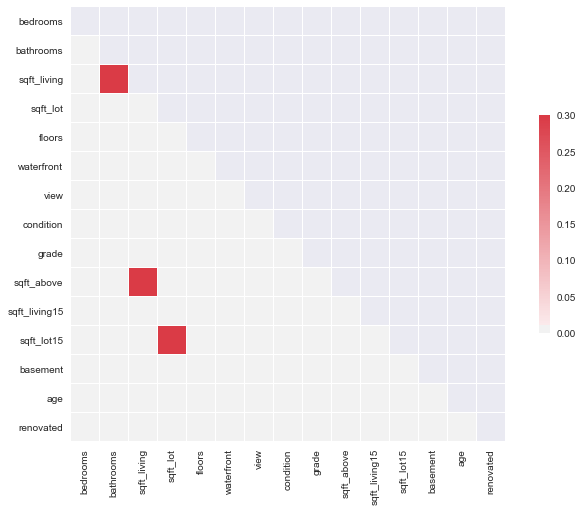

In [52]:
zipless_X = zipless_data.drop('price', axis=1)

corr = abs(zipless_X.corr()) > 0.75
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(12, 8))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


In [53]:
# It looks like we still have issues with multicollinearity, so let's drop the same two columns as our first model.
zipless_X.drop(['sqft_living', 'sqft_lot15'], axis = 1, inplace=True)
zipless_X.head()

,bedrooms,bathrooms,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_living15,basement,age,renovated
0,3,0.000000,8.639411,1.0,0.0,0.0,3,7,7.073270,7.200425,0,8.000000,0
1,3,0.810930,8.887653,2.0,0.0,0.0,3,7,7.682482,7.432484,1,8.246211,1
2,2,0.000000,9.210340,1.0,0.0,0.0,3,6,6.646391,7.908387,0,9.273618,0
3,4,1.098612,8.517193,1.0,0.0,0.0,5,7,6.956545,7.215240,1,7.348469,0
4,3,0.693147,8.997147,1.0,0.0,0.0,3,8,7.426549,7.495542,0,5.656854,0


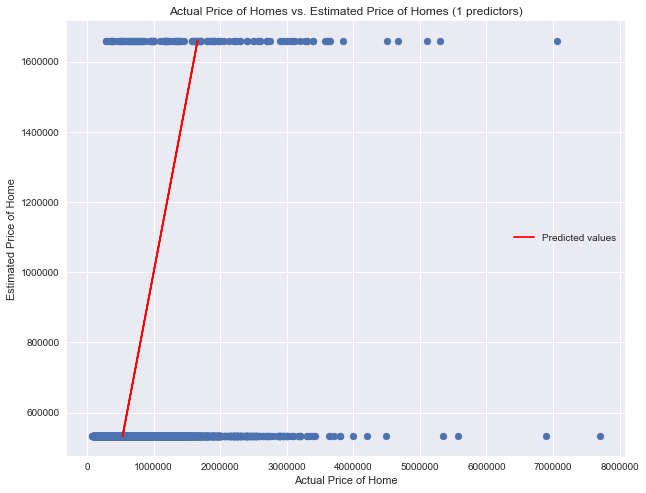

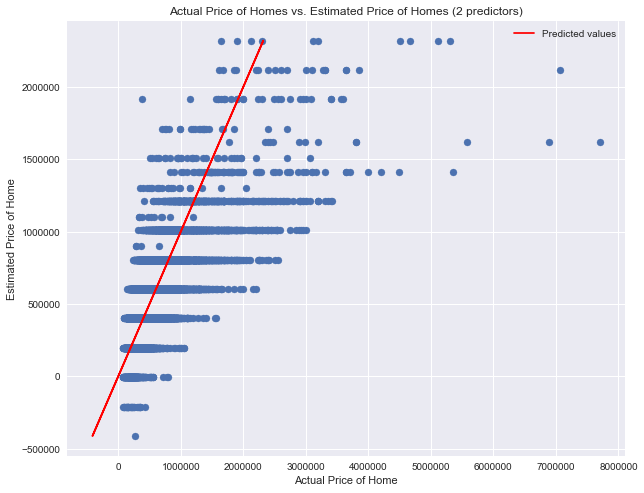

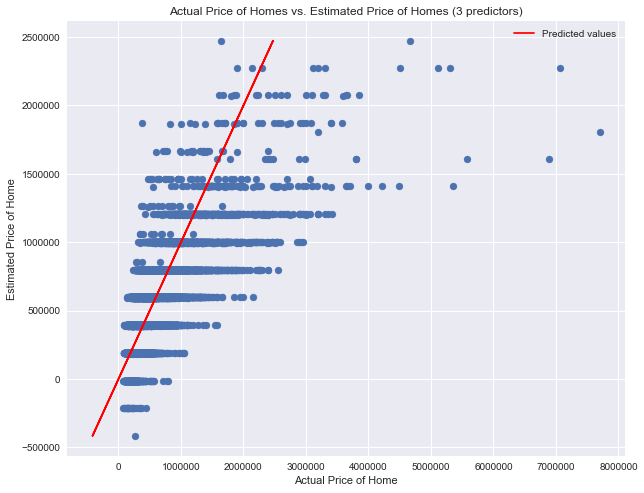

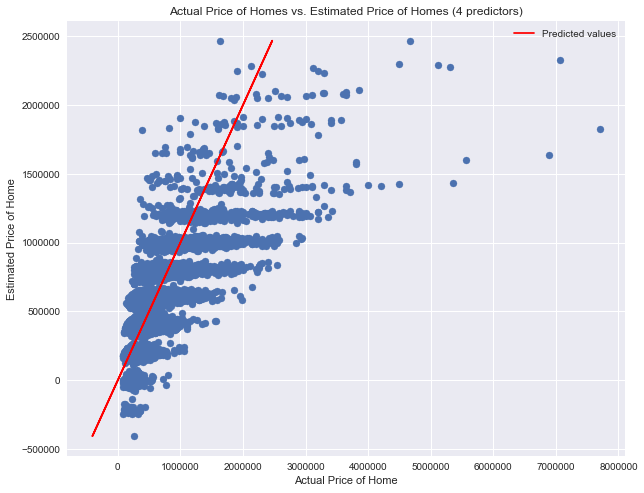

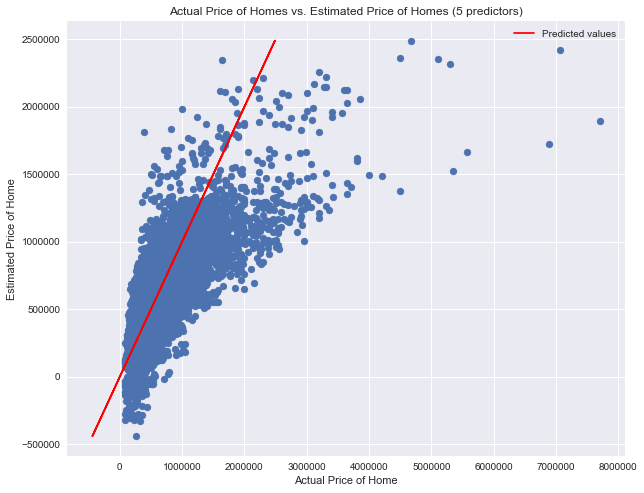

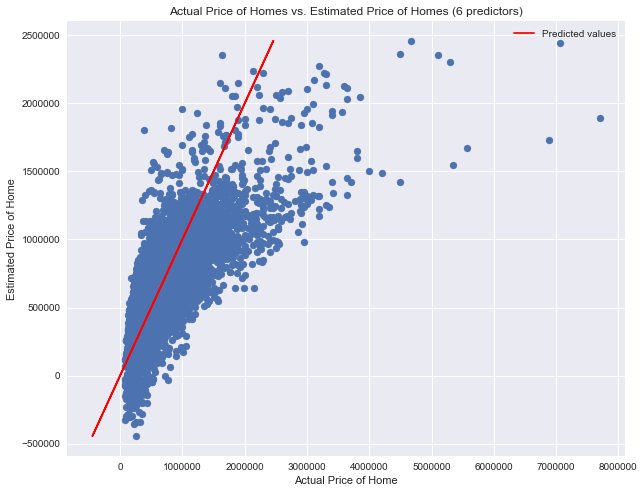

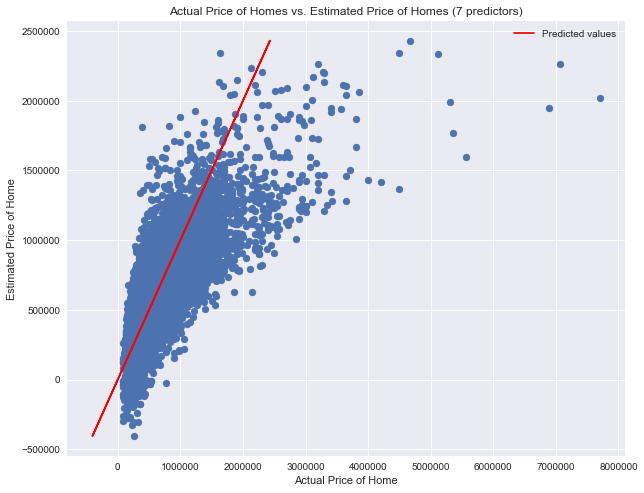

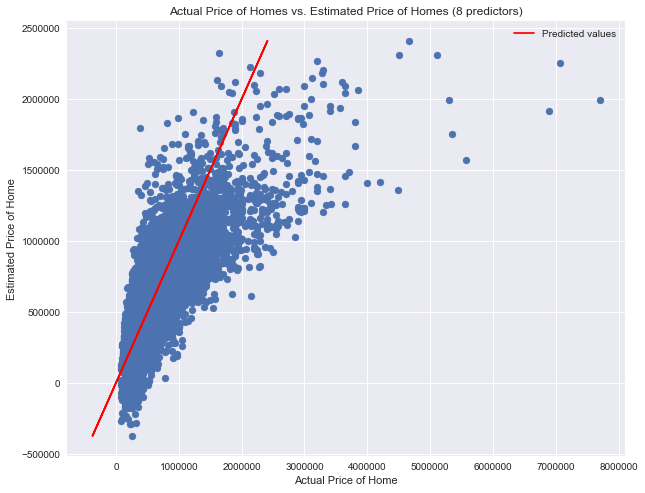

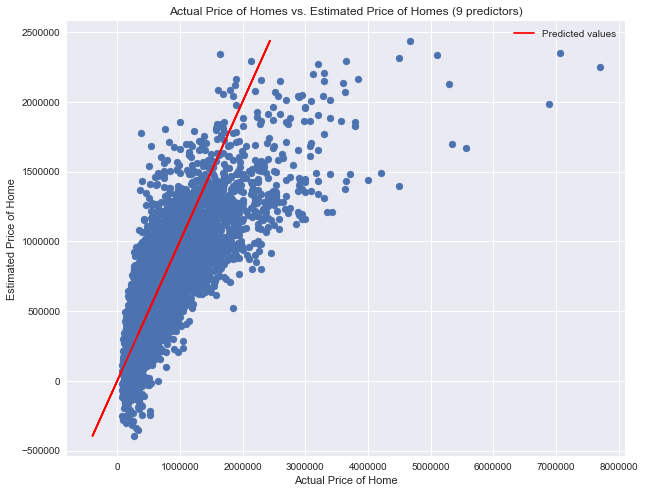

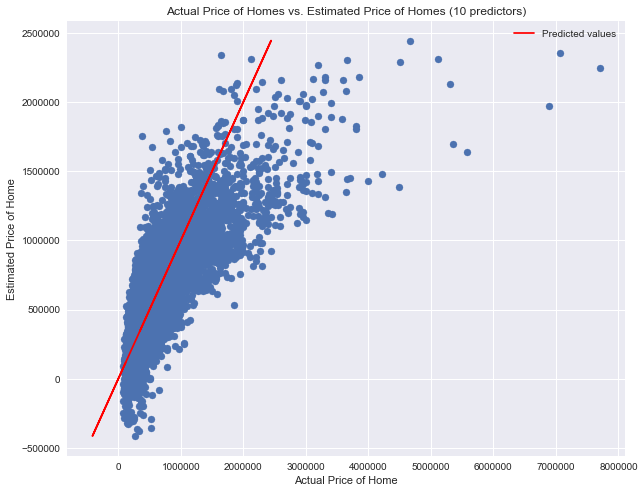

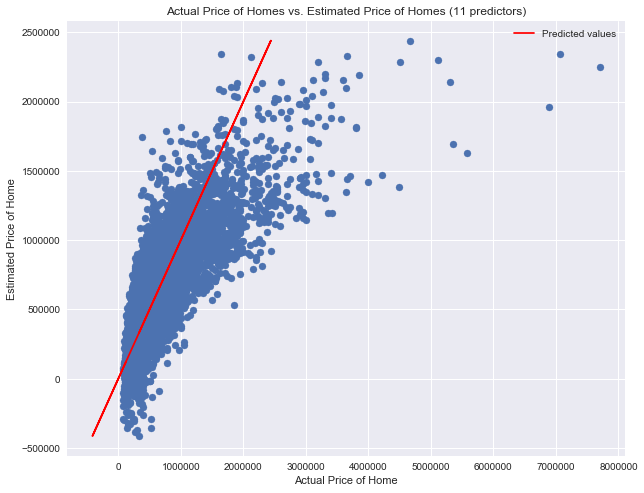

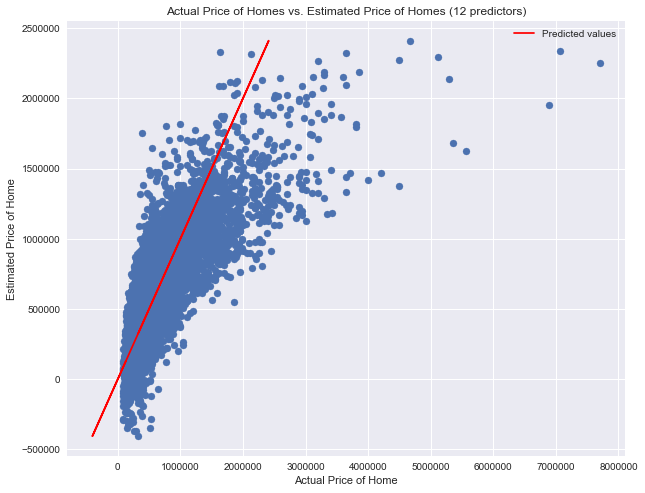

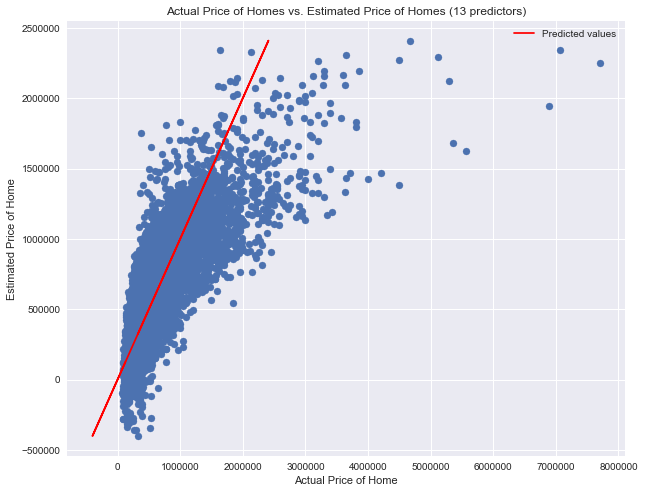

[125934847728.67203, 69204312887.03185, 67937441273.63562, 67334082873.64677, 63490534020.0711, 62991214928.65943, 60366272496.17748, 60214067981.35625, 54860421371.49208, 54244144810.55377, 54046060346.99863, 54002078042.41676, 53953859064.91771]
[124030461901.07614, 67282372596.04349, 66635222700.61849, 65873644042.84453, 61976443433.788284, 61259847314.95845, 58952407055.72175, 58712085408.64439, 53061857534.57477, 52256880354.05729, 52064404692.07817, 51964937079.37025, 51898659946.21022]


In [54]:
mse_trains = []
mse_tests = []
X_train, X_test, y_train, y_test = train_test_split(zipless_X, y, test_size =0.2)

for n in list(range(1, 14)):
    linereg = LinearRegression()
    select_n = RFE(linereg, n_features_to_select = n)
    select_n = select_n.fit(X_train, np.ravel(y_train))
    selected_columns = zipless_X.columns[select_n.support_ ]
    linereg.fit(X_train[selected_columns],y_train)
    
    yhat_train = linereg.predict(X_train[selected_columns])
    yhat_test = linereg.predict(X_test[selected_columns])
    yhat = linereg.predict(zipless_X[selected_columns])
    mse_train = mean_squared_error(yhat_train, y_train)
    mse_test = mean_squared_error(yhat_test, y_test)
    mse_trains.append(mse_train)
    mse_tests.append(mse_test)
    
    plt.figure(figsize = (10,8))
    plt.scatter(y, yhat)
    plt.plot(yhat, yhat, color='red', label='Predicted values')
    plt.xlabel('Actual Price of Home')
    plt.ylabel('Estimated Price of Home')
    plt.title(f'Actual Price of Homes vs. Estimated Price of Homes ({n} predictors)')
    plt.legend()
    plt.show()
print(mse_trains)
print(mse_tests)

In [55]:
X_int = sm.add_constant(zipless_X)
model = sm.OLS(y, X_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.603
Model:                            OLS   Adj. R-squared:                  0.603
Method:                 Least Squares   F-statistic:                     2526.
Date:                Mon, 29 Jul 2019   Prob (F-statistic):               0.00
Time:                        12:50:36   Log-Likelihood:            -2.9739e+05
No. Observations:               21596   AIC:                         5.948e+05
Df Residuals:                   21582   BIC:                         5.949e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -3.022e+06   5.48e+04    -55.145      0.000   -3.13e+06   -2.91e+06
bedrooms      -1.045e+04   2287.340     -4.569      0.000   -1.49e+04   -5967.139
bathrooms       3.51e+04   7187.027      4.883      0.000     2.1e+04    4.92e+04
sqft_lot      -2.896e+04   2208.195    -13.115      0.000   -3.33e+04   -2.46e+04
floors         1.922e+04   4485.645      4.284      0.000    1.04e+04     2.8e+04
waterfront     6.536e+05   2.09e+04     31.343      0.000    6.13e+05    6.94e+05
view           5.621e+04   2380.973     23.609      0.000    5.15e+04    6.09e+04
condition      2.519e+04   2693.147      9.352      0.000    1.99e+04    3.05e+04
grade          1.599e+05   2325.904     68.765      0.000    1.55e+05    1.64e+05
sqft_above     2.015e+05   8785.603     22.933      0.000    1.84e+05    2.19e+05
sqft_living15  8.679e+04   7850.015     11.057      0.000    7.14e+04    1.02e+05
basement       8.651e+04   4204.975     20.574      0.000    7.83e+04    9.48e+04
age            4.508e+04   1058.222     42.596      0.000     4.3e+04    4.72e+04
renovated      5.578e+04   9122.534      6.114      0.000    3.79e+04    7.37e+04
==============================================================================
Omnibus:                    19931.069   Durbin-Watson:                   1.971
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2687837.223
Skew:                           3.998   Prob(JB):                         0.00
Kurtosis:                      57.066   Cond. No.                         629.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [56]:
cv_nmse = cross_val_score(linereg, zipless_X[selected_columns], y, cv=10, scoring="neg_mean_squared_error")

cv_r_squared = cross_val_score(linereg, zipless_X[selected_columns], y, cv=10, scoring="r2")
cv_nmse, cv_r_squared

(array([-5.78748894e+10, -6.22403485e+10, -4.83690295e+10, -6.80241318e+10,
        -4.69677477e+10, -4.74830205e+10, -4.49881090e+10, -4.97612803e+10,
        -5.34884432e+10, -6.30373870e+10]),
 array([0.60002709, 0.60714596, 0.58404833, 0.58648802, 0.57329866,
        0.61658272, 0.63354766, 0.62170707, 0.60409674, 0.54604089]))

Dropping the zip code columns from our data made our model much weaker.  Our r-squared value dropped from .767 to .603, showing a worse goodness of fit.  This is seen through the graphs of our regression model because the cone of scatter points is not as tight around our regression line.  Our error scores were also much higher.  Ultimately, using the zip code information creates a much better model.

## Summary

Using the OSEMN process, we created a multivariate linear regression model to predict house prices in Kings County, Washington.  We loaded in several libraries and the dataset first.  Then, we cleaned the data by replacing null values and sorting out discrepancies in our data.  Next, we explored how our data was distributed.  We did a little extra scrubbing here by transforming columns into more normal distributions.  We continued exploring by looking at some patterns within our data.  Finally, we began to model our data.  We performed a multicollinearity test by running a heatmap of correlation between variables.  Once our trimmed our multicollinearity down, we ran our data through a stepwise selector to only use variables with p-values less than 0.05.  Next, we ran our data through a series of RFE's to make sure that we wanted to use all of our predictors within our model.  Finally, we performed a cross validation to determine goodness of fit for our model.  Once we had a model, we tried two ways to improve the model, removing extreme price points and removing zip code information.  While removing price outliers improved the accuracy of our model, removing the zip code information made our model significantly weaker.  Overall, our model performed well.  Moving forward, I would recomend trying to more accurately predict more expensive home prices.  Perhaps more/different data would be needed.